## cross-electrode phase-locking

## Delta/Theta

In [3]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace, plot_trace2

In [2]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats

## New phase algorithm (peak to trough and trough to peak interpolation)

In [111]:
subj_sess = sessions[0]
print(subj_sess)
bands = OrderedDict([('1-4', [1, 4]),
                     ('4-10', [4, 10])])

# Get session info.
subj_df = phase_locking.get_subj_df()

# Load the raw LFP.
lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                    subj_df=subj_df, 
                                                    notch_freqs=[60, 120],
                                                    interpolate=False)
# Bandpass filter the LFP.
lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                bands=bands, 
                                zscore_lfp=False)

U369_env1


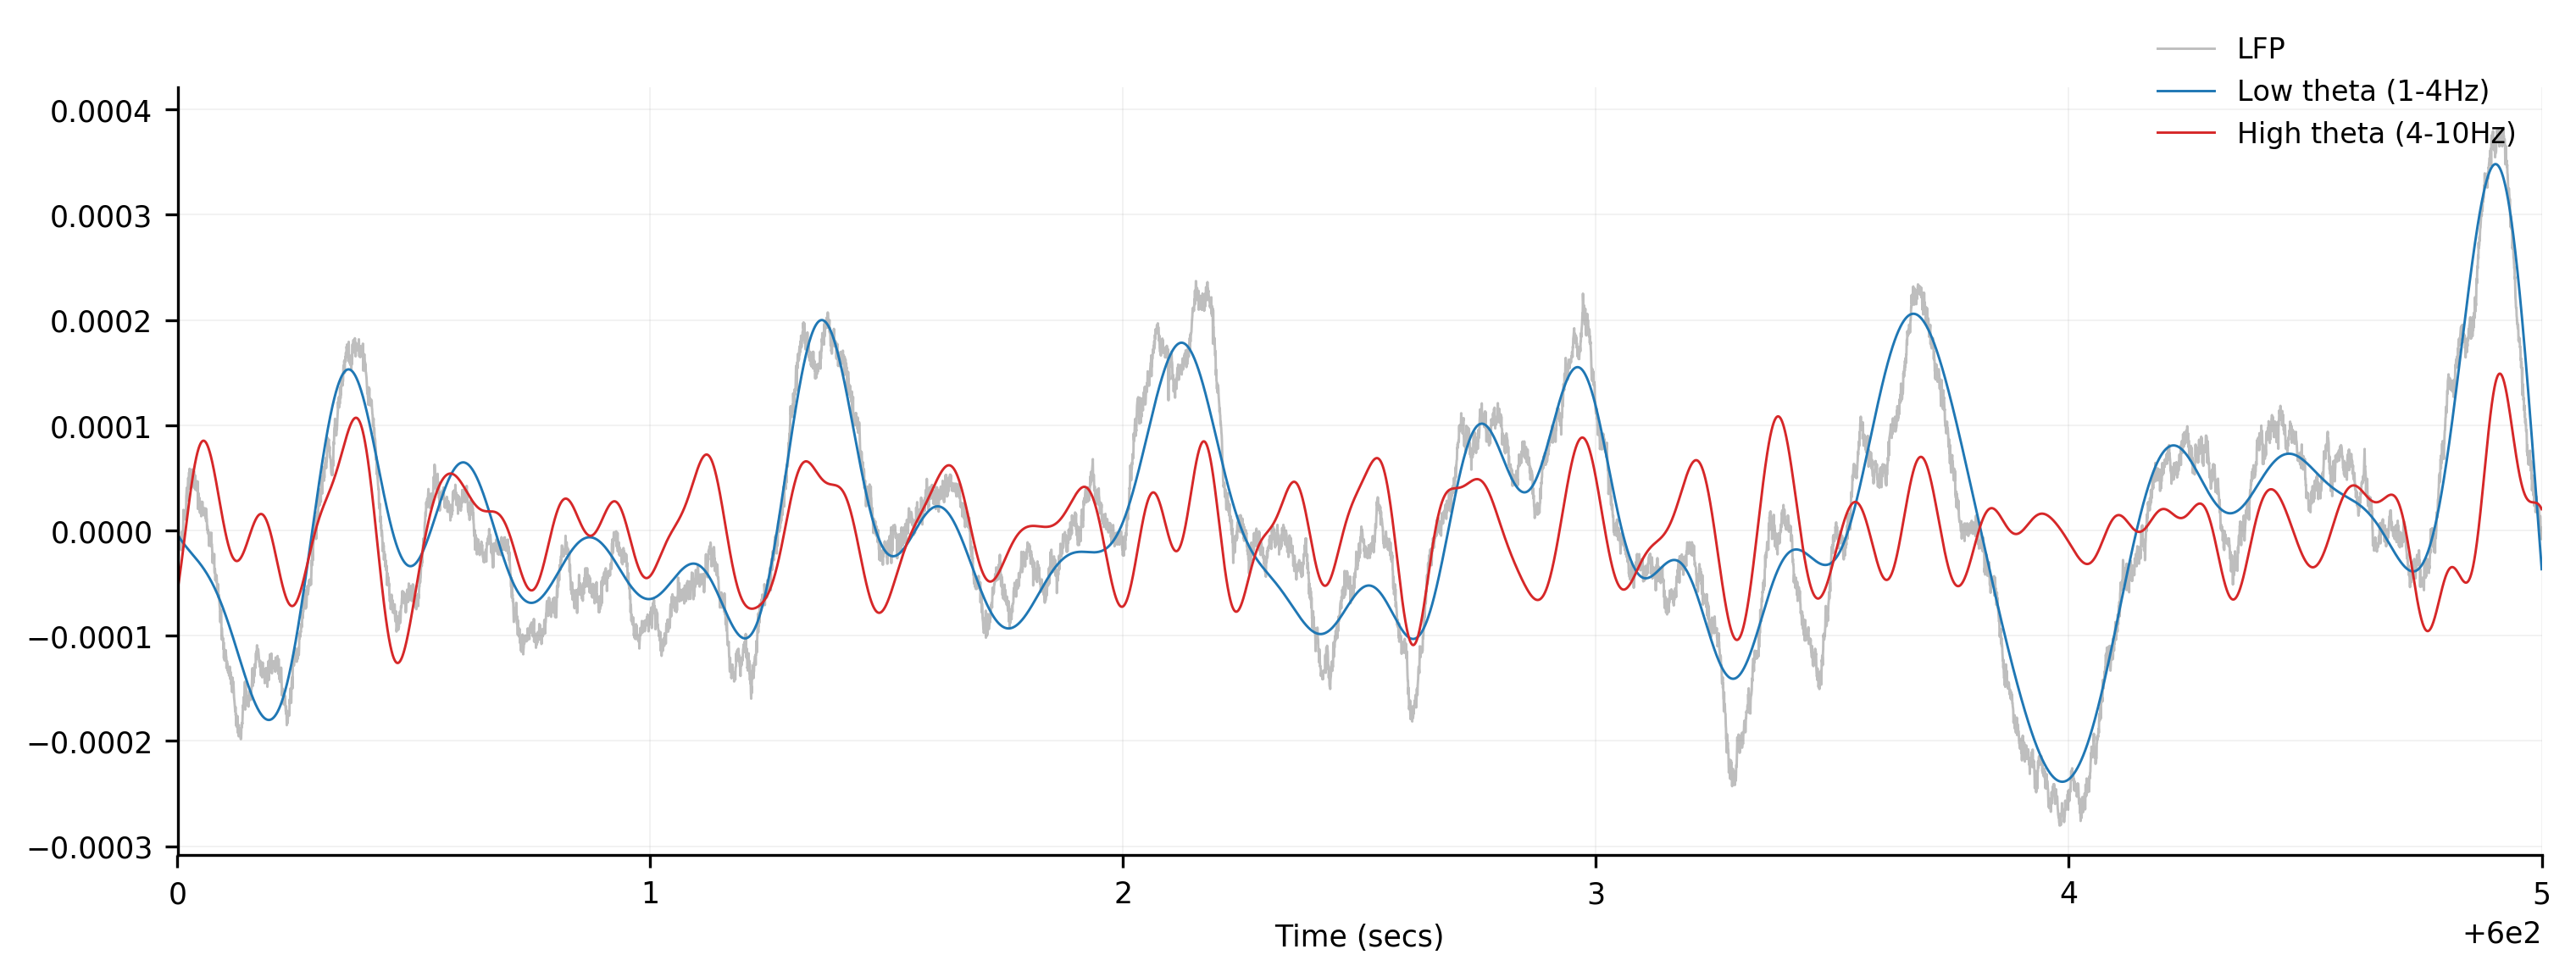

In [609]:
i = 7
dat = np.vstack((lfp_preproc.data[i, :], lfp_filt['1-4'].data[i, :], lfp_filt['4-10'].data[i, :]))

fig, ax = plot_trace(dat, start=600, duration=5, x_units='secs', 
                     colors=['C7', 'C0', 'C1'], alphas=[0.5, 1, 1], 
                     linestyles=['-', '-', '-'],
                     legend_labels=['LFP', 'Low theta (1-4Hz)', 'High theta (4-10Hz)'])

In [224]:
band = '4-10'
cycle_inds, phase = interp_phase(lfp_filt[band].data, find='extrema')

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b384feefdd8>],
       dtype=object))

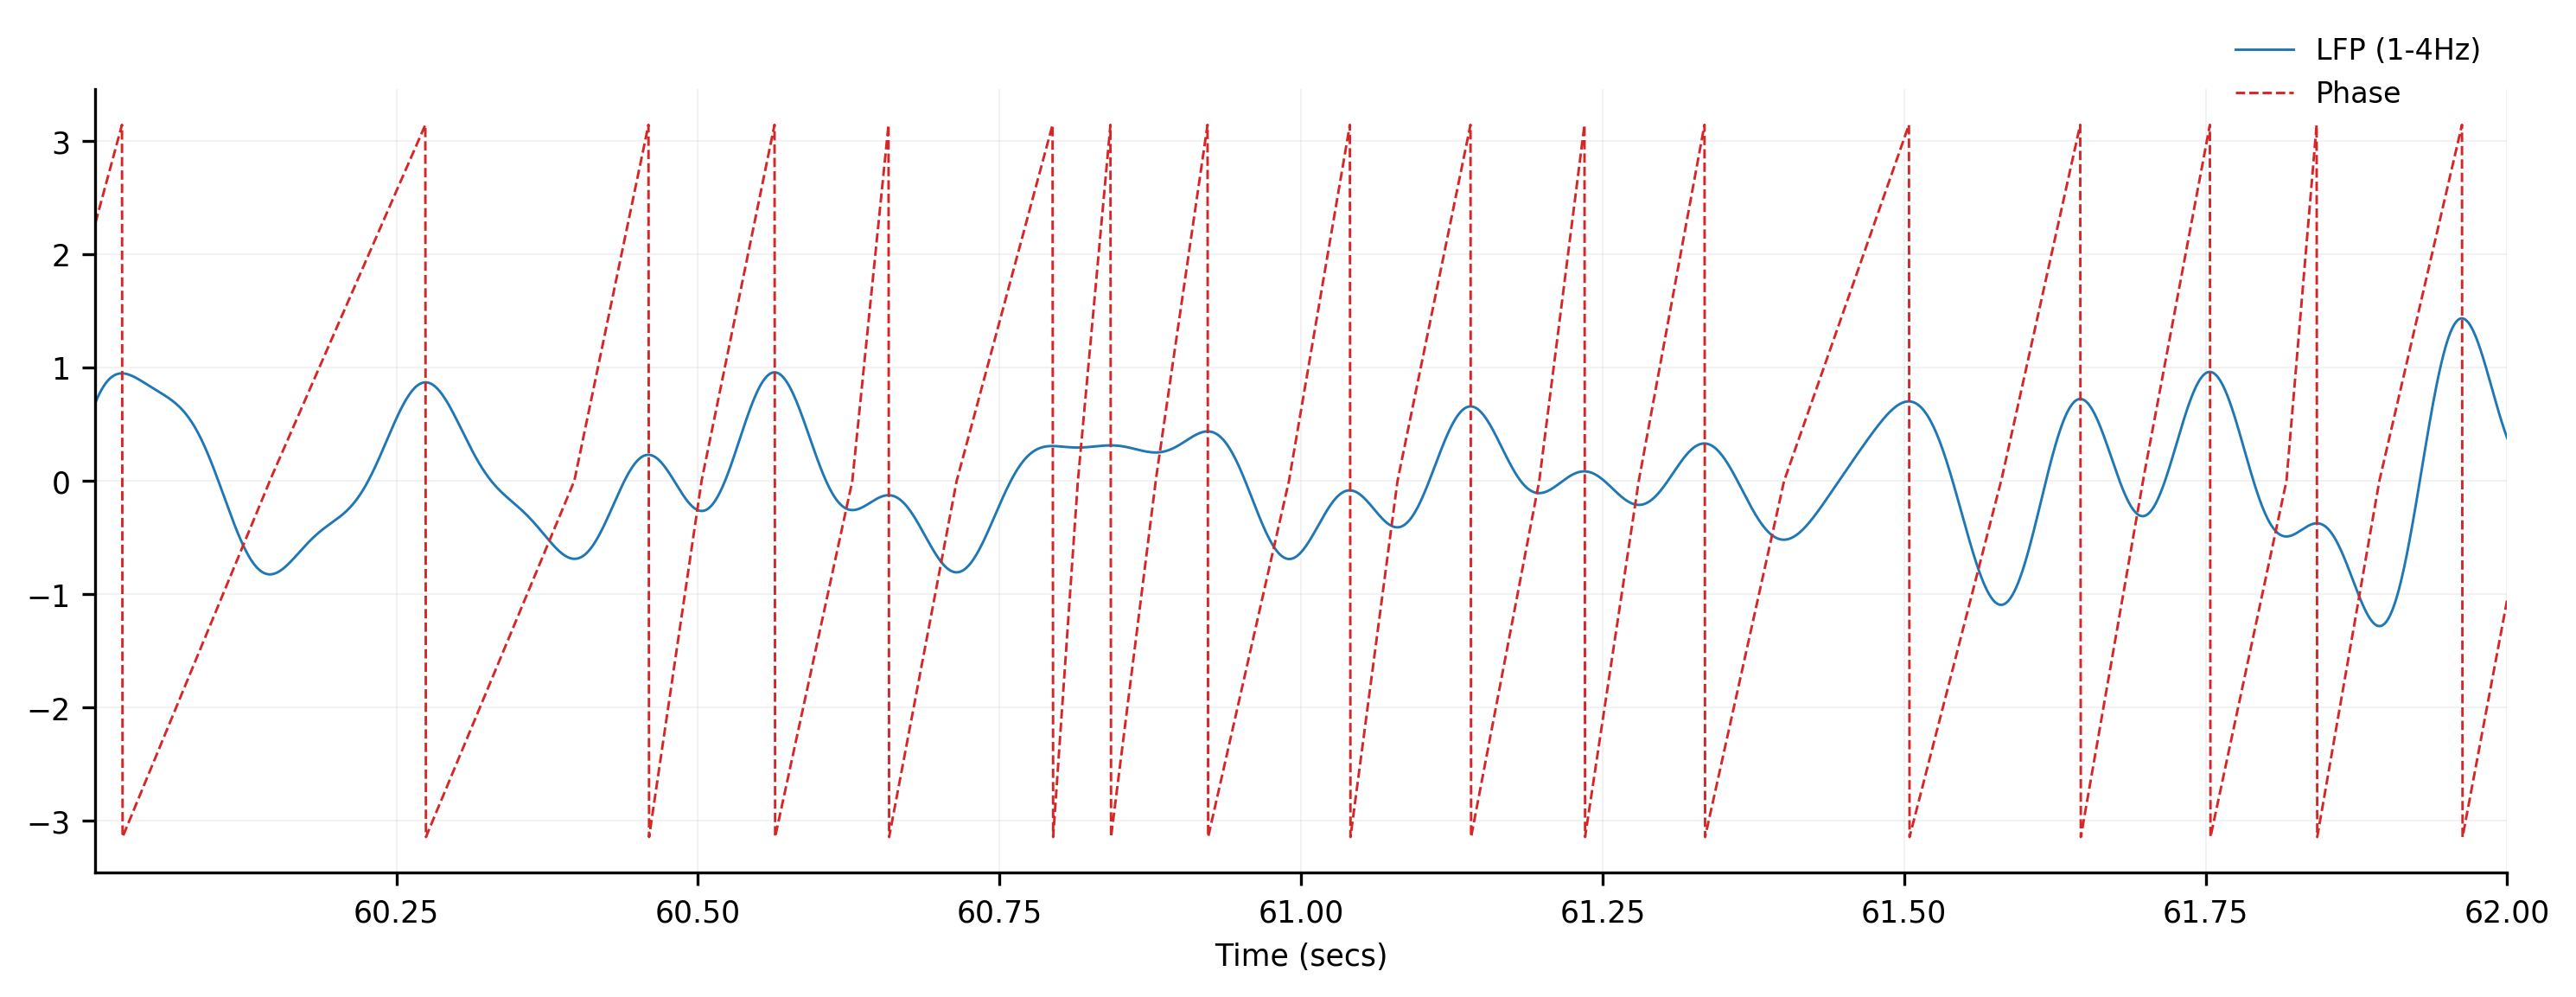

In [225]:
i = 7
plot_trace(np.vstack((stats.zscore(lfp_filt[band][i, :]), phase[i, :])), 
            start=60, duration=2, linestyles=['-', '--'], 
            legend_labels=['LFP (1-4Hz)', 'Phase'])

## Calculate delta and theta phase locking

In [294]:
# Params.
bands = OrderedDict([('delta', [1, 4]),
                     ('theta', [4, 10])])
band_names = list(bands.keys())
bands_fancy = {'delta': 'Delta (1-4 Hz)',
               'theta': 'Theta (4-10 Hz)'}

sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']
sessions = np.sort(sessions)

interp_spikes = False
notch_freqs = [60, 120]
phase_type = 'peaks'
mask_type = None

In [ ]:
# Get a list of all unit-to-LFP pairs for each session, in serial.
for subj_sess in sessions:
    ce_df = get_cross_electrode_unit_lfp_pairs(subj_sess)

In [319]:
# Calculate cycle_stats and inter-electrode phase-locking.
for subj_sess in sessions:
    start_time = time()
    lfp_filt, phase, power, cycle_stats = phase_locking.get_cycle_stats(subj_sess, 
                                                                        bands=bands, 
                                                                        interp_spikes=interp_spikes,
                                                                        notch_freqs=notch_freqs,
                                                                        phase_type=phase_type)
    cepl_df = phase_locking.calc_cross_electrode_phase_locking(subj_sess, 
                                                               bands=bands, 
                                                               interp_spikes=interp_spikes,
                                                               notch_freqs=notch_freqs,
                                                               phase_type=phase_type,
                                                               mask_type=mask_type)
    print('Done in {:.0f} secs'.format(time() - start_time))

## Analyze delta/theta phase-locking results

In [4]:
def invert_dict(d):
    """Invert a dictionary of string keys and list values."""
    if type(d) == dict:
        newd = {}
    else:
        newd = OrderedDict()
    for k, v in d.items():
        for x in v:
            newd[x] = k
    return newd

In [5]:
# Load all cross-electrode files into a single dataframe.
pl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                               '*_crosselec_phaselock_df_notch60-120_nospikeinterp_phase-peaks_nomask_bands--delta1-4--theta4-10.pkl'))

pl_df = dio.open_pickle(pl_files[0])
for f in pl_files[1:]:
    pl_df = pl_df.append(dio.open_pickle(f))
pl_df.reset_index(drop=True, inplace=True)
pl_df_ = pl_df.copy()

In [916]:
pl_df = pl_df_.copy()

In [6]:
shp = pl_df.shape

# Add higher-level ROI mappings.
hemrois = {'lhpc': ['LAH', 'LMH', 'LPH'],
           'lamy': ['LA'],
           'lec': ['LEC'],
           'lphg': ['LPG'],
           'rhpc': ['RAH', 'RMH', 'RPH'],
           'ramy': ['RA'],
           'rec': ['REC'],
           'rphg': ['RPG']}
hemrois['lctx'] = [roi for roi in sorted(set(pl_df.loc[pl_df.lfp_hem=='L'].lfp_hemroi)) 
                   if roi not in list(itertools.chain(*hemrois.values()))]
hemrois['rctx'] = [roi for roi in sorted(set(pl_df.loc[pl_df.lfp_hem=='R'].lfp_hemroi)) 
                   if roi not in list(itertools.chain(*hemrois.values()))]
hemrois_inv = invert_dict(hemrois)
pl_df['unit_hemroi2'] = pl_df.unit_hemroi.agg(lambda x: hemrois_inv[x])
pl_df['lfp_hemroi2'] = pl_df.lfp_hemroi.agg(lambda x: hemrois_inv[x])

rois = {'hpc': ['AH', 'MH', 'PH'],
        'amy': ['A'],
        'ec': ['EC'],
        'phg': ['PG']}
rois['ctx'] = [roi for roi in sorted(set(pl_df.lfp_roi)) if roi not in list(itertools.chain(*rois.values()))]
rois_inv = invert_dict(rois)
pl_df['unit_roi2'] = pl_df.unit_roi.agg(lambda x: rois_inv[x])
pl_df['lfp_roi2'] = pl_df.lfp_roi.agg(lambda x: rois_inv[x])
pl_df['same_roi2'] = pl_df['unit_roi2'] == pl_df['lfp_roi2']

# Remove inter-hemispheric pairs.
pl_df = pl_df.loc[pl_df.same_hem==True]

# Remove units with <200 spikes.
# ADD CODE HERE

# Remove bad channels.
# ADD CODE HERE

# Remove same-channel pairs.
pl_df = pl_df.loc[pl_df.same_chan!=True]

# Remove intra-regional pairs from different microwire bundles.
pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")

# Determine the alpha threshold for each unit-LFP pair. Alpha is Bonferroni-corrected
# by the number of channels in a given region that a unit is compared against to
# determine if it is phase-locked to any channel in that region. E.g., for a 
# R entorhinal unit - R amygdala LFP pair, if there are 8 R amygdala LFPs then the
# significance threshold for this pair is alpha/8. Note that when comparing a R amygdala
# unit to a R amygdala LFP, the threshold would be alpha/7 since we removed same-channel pairs.
alpha = 0.01/2 # 2 for delta and theta comparisons
pl_df['n_comparisons'] = np.array(pl_df.groupby(['subj_sess', 'lfp_hemroi2', 'unit']).unit_lfpchanind.transform(len).tolist())
pl_df['bonf_alpha'] = alpha / np.array(pl_df.groupby(['subj_sess', 'lfp_hemroi2', 'unit']).unit_lfpchanind.transform(len).tolist())

print('Shape changed from {} to {}'.format(shp, pl_df.shape))

Shape changed from (40488, 25) to (20676, 32)


In [7]:
# Figure out which units are phase-locked to which bands. 
arr = (np.array(pl_df.pvals.tolist()).T < np.array(pl_df.bonf_alpha.tolist())).T
pl_df['pl_delta'] = arr[:, 0]
pl_df['pl_theta'] = arr[:, 1]

arr = np.array(pl_df.pvals.tolist())
pl_df['lowest_p'] = np.array(['delta' if x==True else 'theta' for x in arr[:, 0] < arr[:, 1]])

pl_df['pl_delta_wta'] = pl_df.pl_delta.copy()
pl_df.loc[pl_df.lowest_p=='theta', 'pl_delta_wta'] = False
pl_df['pl_theta_wta'] = pl_df.pl_theta.copy()
pl_df.loc[pl_df.lowest_p=='delta', 'pl_theta_wta'] = False

In [13]:
pl_df.columns

Index(['subj_sess', 'unit_lfpchanind', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'lfp_chan',
       'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem', 'lfp_roi', 'lfp_is_hpc',
       'same_chan', 'same_hemroi', 'same_hem', 'same_roi', 'both_hpc',
       'spike_inds', 'spike_phases', 'means', 'lengths', 'pvals',
       'unit_hemroi2', 'lfp_hemroi2', 'unit_roi2', 'lfp_roi2', 'same_roi2',
       'n_comparisons', 'bonf_alpha', 'pl_delta', 'pl_theta', 'lowest_p',
       'pl_delta_wta', 'pl_theta_wta'],
      dtype='object')

In [12]:
# Percent of unit->LFP pairs with significant phase-locking.
print(pl_df.pl_delta_wta.sum(), pl_df.pl_theta_wta.sum(), pl_df.pl_delta_wta.mean(), pl_df.pl_theta_wta.mean())

np.unique(pl_df.query("(pl_delta==True) & (pl_theta==True)").lowest_p, return_counts=True)

1591 1061 0.0769491197523699 0.051315534919713676


(array(['delta', 'theta'], dtype=object), array([522, 486]))

In [17]:
# What percent of 
(pl_df.groupby(['subj_sess', 'unit', 'same_roi2'])
 .agg({'n_comparisons': len,
       'pl_delta_wta': np.sum,
       'pl_theta_wta': np.sum})
 .reset_index()
 .groupby(['same_roi2'])
 .agg({'pl_delta_wta': lambda x: np.sum(x>0)/len(x),
       'pl_theta_wta': lambda x: np.sum(x>0)/len(x)}))

,pl_delta_wta,pl_theta_wta
same_roi2,,
False,0.344774,0.329173
True,0.346334,0.301092


In [11]:
# Make a DataFrame with a row for each unit->region edge, listing
# the number of electrodes in the region that the unit is significantly
# phase-locked to (and whether it is phase-locked to any, or not).
cols = ['subj_sess', 'unit_roi2', 'unit_chan', 'unit', 'lfp_roi2']
df = pl_df.groupby(cols).agg({'n_comparisons': len,
                              'pl_delta': np.sum,
                              'pl_theta': np.sum,
                              'pl_delta_wta': np.sum,
                              'pl_theta_wta': np.sum}).reset_index()
df['pl_delta_pct'] = df.pl_delta / df.n_comparisons
df['pl_theta_pct'] = df.pl_theta / df.n_comparisons
df['pl_delta_wta_pct'] = df.pl_delta_wta / df.n_comparisons
df['pl_theta_wta_pct'] = df.pl_theta_wta / df.n_comparisons

df['pl_delta_bool'] = df.pl_delta > 0
df['pl_theta_bool'] = df.pl_theta > 0

df['pl_delta_wta_bool'] = df.pl_delta_wta > 0
df['pl_theta_wta_bool'] = df.pl_theta_wta > 0
print(df.shape)
df.head(10)

(2393, 18)


,subj_sess,unit_roi2,unit_chan,unit,lfp_roi2,n_comparisons,pl_delta,pl_theta,pl_delta_wta,pl_theta_wta,pl_delta_pct,pl_theta_pct,pl_delta_wta_pct,pl_theta_wta_pct,pl_delta_bool,pl_theta_bool,pl_delta_wta_bool,pl_theta_wta_bool
0,U369_env1,amy,1,0,amy,7,2.0,2.0,2.0,2.0,0.285714,0.285714,0.285714,0.285714,True,True,True,True
1,U369_env1,amy,1,0,ctx,16,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,False,False,False,False
2,U369_env1,amy,1,0,hpc,8,0.0,4.0,0.0,4.0,0.000000,0.500000,0.000000,0.500000,False,True,False,True
3,U369_env1,amy,2,1,amy,7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,False,False,False,False
4,U369_env1,amy,2,1,ctx,16,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,False,False,False,False
5,U369_env1,amy,2,1,hpc,8,0.0,5.0,0.0,5.0,0.000000,0.625000,0.000000,0.625000,False,True,False,True
6,U369_env1,amy,33,40,amy,7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,False,False,False,False
7,U369_env1,amy,33,40,ctx,16,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,False,False,False,False
8,U369_env1,amy,33,40,hpc,8,2.0,4.0,0.0,4.0,0.250000,0.500000,0.000000,0.500000,True,True,False,True
9,U369_env1,amy,34,41,amy,7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,False,False,False,False


In [955]:
# Does phase-locking percentage vary as a function of the number of
# comparisons we are doing between each unit and all the electrodes 
# in each region?
df.groupby(['n_comparisons']).agg({'n_comparisons': len,
                                   'pl_delta': np.mean,
                                   'pl_theta': np.mean,
                                   'pl_delta_wta': np.mean,
                                   'pl_theta_wta': np.mean,
                                   'pl_delta_bool': np.mean,
                                   'pl_theta_bool': np.mean})

,n_comparisons,pl_delta,pl_theta,pl_delta_wta,pl_theta_wta,pl_delta_bool,pl_theta_bool
n_comparisons,,,,,,,
7,640,1.660937,1.539062,1.240625,1.028125,0.484375,0.473438
8,1520,0.826974,0.594079,0.647368,0.420395,0.313158,0.241447
16,190,1.447368,1.052632,1.342105,0.510526,0.342105,0.273684
18,6,2.833333,2.000000,1.500000,1.333333,1.000000,1.000000
24,37,0.459459,0.054054,0.432432,0.054054,0.243243,0.054054


In [983]:
# How many electrodes is each unit phase-locked to?
(df.groupby(['subj_sess', 'unit'])
 .agg({'pl_delta_wta': np.sum,
       'pl_theta_wta': np.sum,
       'pl_delta_wta_bool': np.sum,
       'pl_theta_wta_bool': np.sum})
 .reset_index().head())

,subj_sess,unit,pl_delta_wta,pl_theta_wta,pl_delta_wta_bool,pl_theta_wta_bool
0,U369_env1,0,5.0,6.0,3.0,2.0
1,U369_env1,1,0.0,6.0,0.0,1.0
2,U369_env1,2,1.0,18.0,1.0,3.0
3,U369_env1,3,0.0,0.0,0.0,0.0
4,U369_env1,4,7.0,15.0,2.0,3.0


In [971]:
delta_arr = np.array(df.groupby(['subj_sess', 'unit'])
                     .agg({'pl_delta_wta': np.sum,
                           'pl_theta_wta': np.sum,
                           'pl_delta_wta_bool': np.sum,
                           'pl_theta_wta_bool': np.sum})
                     .reset_index().pl_delta_wta_bool.tolist())

theta_arr = np.array(df.groupby(['subj_sess', 'unit'])
                     .agg({'pl_delta_wta': np.sum,
                           'pl_theta_wta': np.sum,
                           'pl_delta_wta_bool': np.sum,
                           'pl_theta_wta_bool': np.sum})
                     .reset_index().pl_theta_wta_bool.tolist())

In [972]:
np.sum(delta_arr>0)/len(delta_arr), np.sum(theta_arr>0)/len(theta_arr)

(0.609984399375975, 0.6224648985959438)

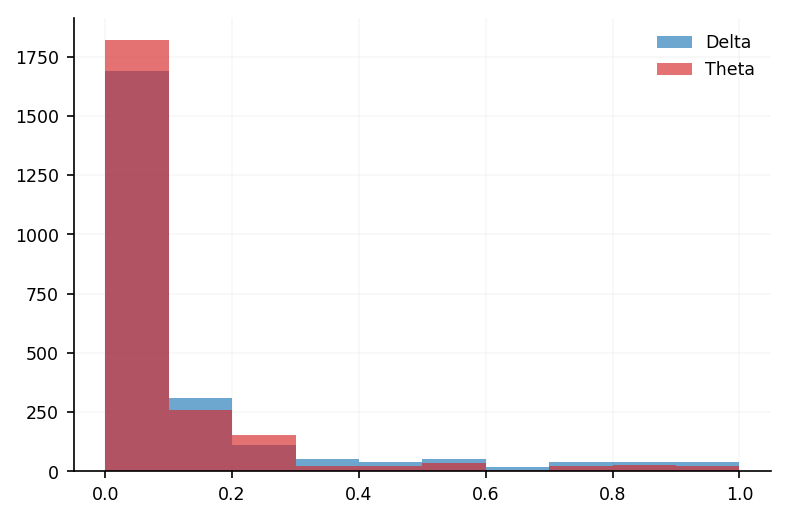

In [992]:
plt.hist(df.pl_delta_wta_pct, alpha=0.65, label='Delta')
plt.hist(df.pl_theta_wta_pct, alpha=0.65, label='Theta')
plt.legend()
# plt.hist(df.loc[df.pl_delta_wta>0].pl_delta_wta / df.loc[df.pl_delta_wta>0].n_comparisons, alpha=0.65)
# plt.hist(df.loc[df.pl_theta_wta>0].pl_theta_wta / df.loc[df.pl_theta_wta>0].n_comparisons, alpha=0.65)

In [999]:
df.query("(unit_roi2==lfp_roi2)").shape, df.query("(unit_roi2!=lfp_roi2)").shape

((641, 18), (1752, 18))

In [993]:
# What percent of units are phase-locked to a channel
# within the same microwire bundle (not including the
# same channel as the unit was recorded from)?
(df.query("(unit_roi2==lfp_roi2)")
 .agg({'pl_delta_bool': np.mean,
       'pl_theta_bool': np.mean,
       'pl_delta_wta_bool': np.mean,
       'pl_theta_wta_bool': np.mean}))

pl_delta_bool        0.485179
pl_theta_bool        0.474259
pl_delta_wta_bool    0.407176
pl_theta_wta_bool    0.377535
dtype: float64

In [994]:
# What percent of units are phase-locked to a channel
# from a different region?
(df.query("(unit_roi2!=lfp_roi2)")
 .agg({'pl_delta_bool': np.mean,
       'pl_theta_bool': np.mean,
       'pl_delta_wta_bool': np.mean,
       'pl_theta_wta_bool': np.mean}))

pl_delta_bool        0.316781
pl_theta_bool        0.243151
pl_delta_wta_bool    0.272831
pl_theta_wta_bool    0.207192
dtype: float64

In [886]:
(df.query("(unit_roi2==lfp_roi2)")
 .groupby(['lfp_roi2'])
 .agg({'pl_delta_bool': np.mean,
       'pl_theta_bool': np.mean,
       'pl_delta_wta_bool': np.mean,
       'pl_theta_wta_bool': np.mean}))

,pl_delta_bool,pl_theta_bool,pl_delta_wta_bool,pl_theta_wta_bool
lfp_roi2,,,,
amy,0.348993,0.295302,0.322148,0.208054
ctx,0.293194,0.371728,0.193717,0.340314
ec,0.243902,0.207317,0.158537,0.158537
hpc,0.550725,0.355072,0.521739,0.239130
phg,0.358025,0.296296,0.296296,0.246914


In [887]:
(df.query("(unit_roi2!=lfp_roi2)")
 .groupby(['lfp_roi2'])
 .agg({'pl_delta_bool': np.mean,
       'pl_theta_bool': np.mean,
       'pl_delta_wta_bool': np.mean,
       'pl_theta_wta_bool': np.mean}))

,pl_delta_bool,pl_theta_bool,pl_delta_wta_bool,pl_theta_wta_bool
lfp_roi2,,,,
amy,0.135447,0.069164,0.132565,0.048991
ctx,0.096085,0.078292,0.088968,0.071174
ec,0.261628,0.212209,0.203488,0.168605
hpc,0.259184,0.234694,0.181633,0.202041
phg,0.148276,0.093103,0.113793,0.086207


In [904]:
(df.groupby(['unit_roi2', 'lfp_roi2'])
 .agg({'pl_delta_bool': np.mean,
       'pl_theta_bool': np.mean,
       'pl_delta_wta_bool': np.mean,
       'pl_theta_wta_bool': np.mean}))

pl_delta_bool  pl_theta_bool  pl_delta_wta_bool  \
unit_roi2 lfp_roi2                                                    
amy       amy            0.348993       0.295302           0.322148   
          ctx            0.058140       0.116279           0.046512   
          ec             0.431579       0.400000           0.336842   
          hpc            0.384058       0.311594           0.333333   
          phg            0.172840       0.049383           0.135802   
ctx       amy            0.067797       0.042373           0.067797   
          ctx            0.293194       0.371728           0.193717   
          ec             0.135135       0.135135           0.072072   
          hpc            0.141361       0.115183           0.083770   
          phg            0.111111       0.097222           0.083333   
ec        amy            0.175439       0.105263           0.175439   
          ctx            0.033333       0.016667           0.033333   
          ec             0.243902       0.207317           0.158537   
          hpc            0.375000       0.387500           0.250000   
          phg            0.033333       0.033333           0.033333   
hpc       amy            0.265306       0.132653           0.255102   
          ctx            0.182796       0.086022           0.172043   
          ec             0.400000       0.250000           0.350000   
          hpc            0.550725       0.355072           0.521739   
          phg            0.246753       0.181818           0.181818   
phg       amy            0.040541       0.000000           0.040541   
          ctx            0.071429       0.071429           0.071429   
          ec             0.034483       0.000000           0.034483   
          hpc            0.209877       0.234568           0.086420   
          phg            0.358025       0.296296           0.296296   

                    pl_theta_wta_bool  
unit_roi2 lfp_roi2                     
amy       amy                0.208054  
          ctx                0.093023  
          ec                 0.326316  
          hpc                0.268116  
          phg                0.049383  
ctx       amy                0.042373  
          ctx                0.340314  
          ec                 0.108108  
          hpc                0.094241  
          phg                0.083333  
ec        amy                0.070175  
          ctx                0.016667  
          ec                 0.158537  
          hpc                0.325000  
          phg                0.033333  
hpc       amy                0.081633  
          ctx                0.086022  
          ec                 0.187500  
          hpc                0.239130  
          phg                0.168831  
phg       amy                0.000000  
          ctx                0.071429  
          ec                 0.000000  
          hpc                0.222222  
          phg                0.246914

- Hippocampus:  109 138
- Parahippocampal:  143 163
- Amygdala:  116 149
- Frontal:  53 69
- Cortex (Other):  104 122

In [18]:
138 + 163 + 149 + 69 + 122

641

In [9]:
df.columns

NameError: name 'df' is not defined

In [795]:
df.groupby(['unit_roi2', 'lfp_roi2']).unit.agg([len, lambda x: len(np.unique(x))])

len  <lambda>
unit_roi2 lfp_roi2               
amy       amy       149        60
          ctx        86        43
          ec         95        56
          hpc       138        60
          phg        81        52
ctx       amy       118        53
          ctx       191        67
          ec        111        58
          hpc       191        67
          phg        72        48
ec        amy        57        35
          ctx        60        30
          ec         82        35
          hpc        80        35
          phg        60        27
hpc       amy        98        47
          ctx        93        55
          ec         80        40
          hpc       138        58
          phg        77        34
phg       amy        74        38
          ctx        42        32
          ec         58        35
          hpc        81        44
          phg        81        44

In [796]:
# How many comparisons are we making between each region and eath other region,
# and how many units are compared?
pl_df.groupby(['unit_roi2', 'lfp_roi2']).unit.agg([len, lambda x: len(np.unique(x))])

len  <lambda>
unit_roi2 lfp_roi2                
amy       amy       1043        60
          ctx       1128        43
          ec         760        56
          hpc       1344        60
          phg        648        52
ctx       amy        944        53
          ctx       1338        67
          ec         888        58
          hpc       1528        67
          phg        576        48
ec        amy        456        35
          ctx        944        30
          ec         574        35
          hpc        784        35
          phg        480        27
hpc       amy        784        47
          ctx       1260        55
          ec         640        40
          hpc        966        58
          phg        616        34
phg       amy        592        38
          ctx        504        32
          ec         464        35
          hpc        848        44
          phg        567        44

In [616]:
df = pl_df.groupby(['subj_sess', 'lfp_hemroi2']).lfp_chan_ind.unique().reset_index()
alpha = 0.05
df['n_chan'] = df.lfp_chan_ind.agg(lambda x: len(x))
df['bonf_alpha'] = df.lfp_chan_ind.agg(lambda x: alpha/len(x))
df.head(20)

,subj_sess,lfp_hemroi2,lfp_chan_ind,n_chan,bonf_alpha
0,U369_env1,lamy,"[33, 34, 35, 36, 37, 38, 39, 32]",8,0.006250
1,U369_env1,lctx,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...",16,0.003125
2,U369_env1,lhpc,"[40, 41, 42, 43, 44, 45, 46, 47]",8,0.006250
3,U369_env1,ramy,"[1, 2, 3, 4, 5, 6, 7, 0]",8,0.006250
4,U369_env1,rctx,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",16,0.003125
5,U369_env1,rhpc,"[8, 9, 10, 11, 12, 13, 14, 15]",8,0.006250
6,U369_env2,lamy,"[33, 34, 35, 36, 37, 38, 39, 32]",8,0.006250
7,U369_env2,lctx,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...",16,0.003125
8,U369_env2,lhpc,"[40, 41, 42, 43, 44, 45, 46, 47]",8,0.006250
9,U369_env2,ramy,"[1, 2, 3, 4, 5, 6, 7, 0]",8,0.006250


In [621]:
# Determine the alpha threshold for each unit-LFP pair. Alpha is Bonferroni-corrected
# by the number of channels in a given region that a unit is compared against to
# determine whether it is phase-locked to any channel in that region.
# E.g. for a R entorhinal unit - R amygdala LFP pair, if there are 8 R amygdala LFPs then
# threshold for significance of this pair is alpha/8. Note that for comparing a R amygdala
# unit to a R amygdala LFP, the threshold would be alpha/7 since we removed same-channel pairs.
pl_df = pd.merge(pl_df, df[['subj_sess', 'lfp_hemroi2', 'n_chan']], how='left', on=['subj_sess', 'lfp_hemroi2'])
pl_df.loc[pl_df.same_hemroi==True, 'n_chan'] -= 1

In [641]:
print(np.unique(pl_df.n_chan, return_counts=True), np.unique(df.unit_lfpchanind, return_counts=True), sep='\n\n')

(array([ 6,  7,  8, 15, 16, 17, 18, 23, 24]), array([    7,  3248, 12152,   826,  3040,     8,   108,   399,   888]))

(array([ 7,  8, 16, 18, 24]), array([ 4480, 12160,  3040,   108,   888]))


In [ ]:
alpha = 0.05
pl_df['bonf_alpha'] = alpha / np.array(pl_df.groupby(['subj_sess', 'lfp_hemroi2', 'unit']).unit_lfpchanind.transform(len).tolist())

In [680]:
1

1

In [667]:
df = pl_df.groupby(['subj_sess', 'lfp_hemroi2', 'unit']).unit_lfpchanind.count().reset_index()
df.rename(columns={'unit_lfpchanind': 'nchan2'}, inplace=True)

df = pd.merge(pl_df, df, how='left', on=['subj_sess', 'lfp_hemroi2', 'unit'])
v = np.array(df.nchan2.tolist())

In [683]:
np.unique(pl_df.bonf_alpha, return_counts=True)

(array([0.00208333, 0.00277778, 0.003125  , 0.00625   , 0.00714286]),
 array([  888,   108,  3040, 12160,  4480]))

In [682]:
pl_df[['subj_sess', 'lfp_hemroi2', 'unit', 'bonf_alpha']].head(20)

,subj_sess,lfp_hemroi2,unit,bonf_alpha
1,U369_env1,ramy,0,0.007143
2,U369_env1,ramy,0,0.007143
3,U369_env1,ramy,0,0.007143
4,U369_env1,ramy,0,0.007143
5,U369_env1,ramy,0,0.007143
6,U369_env1,ramy,0,0.007143
7,U369_env1,ramy,0,0.007143
8,U369_env1,rhpc,0,0.006250
9,U369_env1,rhpc,0,0.006250
10,U369_env1,rhpc,0,0.006250


In [475]:
grp = pl_df.groupby(['subj_sess', 'lfp_hemroi2']) # need to account for hemisphere since we're dropping interhem comparisons...
df = pd.DataFrame(grp.lfp_chan_ind.unique()).reset_index()
alpha = 0.05
df['n_chan'] = df.lfp_chan_ind.agg(lambda x: len(x))
df['bonf_alpha'] = df.lfp_chan_ind.agg(lambda x: alpha/len(x))
df.head(10)

,subj_sess,lfp_hemroi2,lfp_chan_ind,n_chan,bonf_alpha
0,U369_env1,lamy,"[32, 33, 34, 35, 36, 37, 38, 39]",8,0.006250
1,U369_env1,lctx,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...",16,0.003125
2,U369_env1,lhpc,"[40, 41, 42, 43, 44, 45, 46, 47]",8,0.006250
3,U369_env1,ramy,"[0, 1, 2, 3, 4, 5, 6, 7]",8,0.006250
4,U369_env1,rctx,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",16,0.003125
5,U369_env1,rhpc,"[8, 9, 10, 11, 12, 13, 14, 15]",8,0.006250
6,U369_env2,lamy,"[32, 33, 34, 35, 36, 37, 38, 39]",8,0.006250
7,U369_env2,lctx,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...",16,0.003125
8,U369_env2,lhpc,"[40, 41, 42, 43, 44, 45, 46, 47]",8,0.006250
9,U369_env2,ramy,"[0, 1, 2, 3, 4, 5, 6, 7]",8,0.006250


In [515]:
# Get a dict of channels to remove, by session.
bad_chans_ = dio.open_pickle('/data3/scratch/dscho/frLfp/data/other/bad_chans_auto_detection.pkl')
bad_chans_manual = dio.open_pickle('/data3/scratch/dscho/frLfp/data/other/bad_chans_manual.pkl')
bad_chans = OrderedDict()
for subj_sess in sessions:
    bad_chans[subj_sess] = (bad_chans_.get(subj_sess, {'bad_std': []})['bad_std'] + 
                            bad_chans_.get(subj_sess, {'bad_diff': []})['bad_diff'] + 
                            bad_chans_.get(subj_sess, {'bad_both': []})['bad_both'] + 
                            bad_chans_manual.get(subj_sess, []))

In [573]:
pl_df['bad_chan'] = 0
inds = []
for subj_sess in bad_chans.keys():
    bad_chans_ = bad_chans[subj_sess]
    df = pl_df.query("(subj_sess=='{}') & (unit_chan=={})".format(subj_sess, bad_chans_))
    inds += df.index.tolist()
    df = pl_df.query("(subj_sess=='{}') & (lfp_chan=={})".format(subj_sess, bad_chans_))
    inds += df.index.tolist()
inds = list(set(inds))
pl_df.loc[inds, 'bad_chan'] = 1

In [564]:
bad_chans

OrderedDict([('U369_env1', ['47', '19', '45']),
             ('U369_env2', ['41', '19', '20', '47']),
             ('U371_env2', ['11', '12', '13', '15']),
             ('U371_env3', ['10', '12', '13', '14', '15', '16', '17', '46']),
             ('U372_ses2', ['25', '21', '22', '23', '24', '43', '47']),
             ('U373_ses1', ['57', '58', '64', 42, 43]),
             ('U380_ses2', ['8', '41', '44', '45', '28', '57']),
             ('U384_ses3', ['49', '50', '5', '42', '43', '31']),
             ('U385_ses4', ['48']),
             ('U387_ses1', ['42']),
             ('U387_ses3', ['33']),
             ('U390_ses3', ['28', '35', '25', '34', 42, 43]),
             ('U393_ses2',
              ['28', '62', '63', '24', '29', '30', '31', '32', '51']),
             ('U395_ses2', ['12', '15', '16'])])

In [575]:
pl_df.loc[pl_df.bad_chan==1][['subj_sess', 'unit_chan', 'lfp_chan', 'unit_roi2', 'lfp_roi2']]

,subj_sess,unit_chan,lfp_chan,unit_roi2,lfp_roi2
18,U369_env1,1,19,amy,ctx
82,U369_env1,2,19,amy,ctx
146,U369_env1,4,19,amy,ctx
210,U369_env1,4,19,amy,ctx
274,U369_env1,5,19,amy,ctx
338,U369_env1,5,19,amy,ctx
402,U369_env1,6,19,amy,ctx
466,U369_env1,6,19,amy,ctx
530,U369_env1,6,19,amy,ctx
594,U369_env1,7,19,amy,ctx


In [578]:
bad_chans

OrderedDict([('U369_env1', ['47', '19', '45']),
             ('U369_env2', ['41', '19', '20', '47']),
             ('U371_env2', ['11', '12', '13', '15']),
             ('U371_env3', ['10', '12', '13', '14', '15', '16', '17', '46']),
             ('U372_ses2', ['25', '21', '22', '23', '24', '43', '47']),
             ('U373_ses1', ['57', '58', '64', 42, 43]),
             ('U380_ses2', ['8', '41', '44', '45', '28', '57']),
             ('U384_ses3', ['49', '50', '5', '42', '43', '31']),
             ('U385_ses4', ['48']),
             ('U387_ses1', ['42']),
             ('U387_ses3', ['33']),
             ('U390_ses3', ['28', '35', '25', '34', 42, 43]),
             ('U393_ses2',
              ['28', '62', '63', '24', '29', '30', '31', '32', '51']),
             ('U395_ses2', ['12', '15', '16'])])

In [503]:

pl_df[['subj_sess', 'unit_chan', 'lfp_chan']]

,subj_sess,unit_chan,lfp_chan
0,U369_env1,1,1
1,U369_env1,1,2
2,U369_env1,1,3
3,U369_env1,1,4
4,U369_env1,1,5
5,U369_env1,1,6
6,U369_env1,1,7
7,U369_env1,1,8
8,U369_env1,1,9
9,U369_env1,1,10


In [507]:
pl_df.loc[pl_df.subj_sess==sessions[0]].lfp_chan, bad_chans[sessions[0]]

(0        1
 1        2
 2        3
 3        4
 4        5
 5        6
 6        7
 7        8
 8        9
 9       10
 10      11
 11      12
 12      13
 13      14
 14      15
 15      16
 16      17
 17      18
 18      19
 19      20
 20      21
 21      22
 22      23
 23      24
 24      25
 25      26
 26      27
 27      28
 28      29
 29      30
         ..
 3938    35
 3939    36
 3940    37
 3941    38
 3942    39
 3943    40
 3944    41
 3945    42
 3946    43
 3947    44
 3948    45
 3949    46
 3950    47
 3951    48
 3952    49
 3953    50
 3954    51
 3955    52
 3956    53
 3957    54
 3958    55
 3959    56
 3960    57
 3961    58
 3962    59
 3963    60
 3964    61
 3965    62
 3966    63
 3967    64
 Name: lfp_chan, Length: 1984, dtype: object,
 {'good': ['1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '16',
   '17',
   '18',
   '20',
   '21',
   '22',
   '23',
   '24',
   '25',
   '26'

In [524]:
bad_chans

OrderedDict([('U369_env1', ['47', '19', '45']),
             ('U369_env2', ['41', '19', '20', '47']),
             ('U371_env2', ['11', '12', '13', '15']),
             ('U371_env3', ['10', '12', '13', '14', '15', '16', '17', '46']),
             ('U372_ses2', ['25', '21', '22', '23', '24', '43', '47']),
             ('U373_ses1', ['57', '58', '64', 42, 43]),
             ('U380_ses2', ['8', '41', '44', '45', '28', '57']),
             ('U384_ses3', ['49', '50', '5', '42', '43', '31']),
             ('U385_ses4', ['48']),
             ('U387_ses1', ['42']),
             ('U387_ses3', ['33']),
             ('U390_ses3', ['28', '35', '25', '34', 42, 43]),
             ('U393_ses2',
              ['28', '62', '63', '24', '29', '30', '31', '32', '51']),
             ('U395_ses2', ['12', '15', '16'])])

## Calculate 5-band phase locking

In [74]:
# Instantiate LFP bands.
bands = OrderedDict([('low_theta', [1, 5]),
                     ('high_theta', [5, 10]),
                     ('alpha_beta', [10, 20]),
                     ('low_gamma', [30, 50]),
                     ('mid_gamma', [70, 90]),
                     ('high_gamma', [90, 110])])
band_names = list(bands.keys())
bands_fancy = {'low_theta': 'Low theta (1-5 Hz)',
               'high_theta': 'High theta (5-10 Hz)',
               'alpha_beta': 'Alpha-beta (10-20 Hz)',
               'low_gamma': 'Low gamma (30-50 Hz)',
               'mid_gamma': 'Mid gamma (70-90 Hz)',
               'high_gamma': 'High gamma (90-110 Hz)'}

In [75]:
# Get a list of sessions to include in the analysis.
sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']
sessions = np.sort(sessions)

In [134]:
# Get a list of all unit-to-LFP pairs for each session, in serial.
for subj_sess in sessions:
    ce_df = get_cross_electrode_unit_lfp_pairs(subj_sess)

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U369_env1_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U369_env2_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U371_env2_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U371_env3_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U372_ses2_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U373_ses1_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U380_ses2_cross_electrode_unit_lfp_pairs_df.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U384_ses3_cross_electrode_unit_lfp_pairs

In [ ]:
# Calculate cross-unit phase-locking for each session, in serial.
start_time = time()
for subj_sess in sessions:
    cepl_df = phase_locking.calc_cross_electrode_phase_locking(subj_sess, bands=bands, interp_spikes=True)
print('Done in {:.0f} secs'.format(time() - start_time))

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U369_env1_cross_electrode_phase_locking_unit_lfp_pairs_df_None_peaks_25powpct_3osclength.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U369_env2_cross_electrode_phase_locking_unit_lfp_pairs_df_None_peaks_25powpct_3osclength.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U371_env2_cross_electrode_phase_locking_unit_lfp_pairs_df_None_peaks_25powpct_3osclength.pkl
Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crossunit_phase_locking/U371_env3_cross_electrode_phase_locking_unit_lfp_pairs_df_None_peaks_25powpct_3osclength.pkl


In [143]:
# Load all cross-electrode files into a single dataframe.
cepl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                               '*_cross_electrode_phase_locking_df_no-mask_cycle-peaks_lininterp-phase_25powpct_3osclength_interp-spikes-True_notch60-120.pkl'))

cepl_df = dio.open_pickle(cepl_files[0])
for f in cepl_files[1:]:
    cepl_df = cepl_df.append(dio.open_pickle(f))
cepl_df.reset_index(drop=True, inplace=True)

In [144]:
cepl_df.shape

(40488, 25)

In [29]:
bonf_alpha = 0.05/6

In [30]:
cepl_df.columns

Index(['subj_sess', 'unit_lfpchanind', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'lfp_chan',
       'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem', 'lfp_roi', 'lfp_is_hpc',
       'same_chan', 'same_hemroi', 'same_hem', 'same_roi', 'both_hpc',
       'spike_inds', 'spike_phases', 'means', 'lengths', 'pvals'],
      dtype='object')

In [160]:
cepl_df.query("(same_chan==True)").shape, cepl_df.query("(same_chan==False) & (same_hemroi==True)").shape, cepl_df.query("(same_hemroi==False)").shape

((641, 25), (4488, 25), (35359, 25))

In [32]:
np.unique(cepl_df.unit_roi, return_counts=True)

(array(['A', 'AC', 'AH', 'EC', 'MC', 'MH', 'MST', 'OF', 'PG', 'PH', 'PO',
        'PS', 'PST', 'SAO', 'SMA', 'ST', 'TP'], dtype=object),
 array([9536,  936, 6208, 5184, 1216, 1344,  768, 2680, 5148, 1088,  512,
        1920,  192,  116,  640, 2496,  504]))

In [162]:
df = cepl_df.copy()
df['pair_type'] = 0
df.loc[(df.same_chan==True), 'pair_type'] = 'same_channel'
df.loc[(df.same_chan==False) & (df.same_hemroi==True), 'pair_type'] = 'same_bundle'
df.loc[(df.same_chan==False) & (df.same_hemroi==False), 'pair_type'] = 'diff_bundle'
df['bundle_id'] = df.subj_sess + '_' + df.unit_hemroi
df['unit_id'] = df.subj_sess + '_' + df.unit.astype(str)
df['pair_id'] = df.subj_sess + '_' + df.unit_lfpchanind
for i, band_name in enumerate(band_names):
    df['pl_{}'.format(band_name)] = df.pvals.apply(lambda x: x[i]<bonf_alpha)

In [407]:
subj_sess_to_hpc_chan_inds = df.query("(lfp_is_hpc==True)").groupby('subj_sess').lfp_chan_ind.unique().to_dict()
bonf_alphas = np.array([0.05/len(subj_sess_to_hpc_chan_inds[subj_sess]) for subj_sess in df.subj_sess.tolist()])
arr = np.array(df.pvals.tolist()) < np.tile(bonf_alphas, 6).reshape([6, len(bonf_alphas)]).T
df['pvals_hpcbonf'] = [x for x in arr]

In [414]:
for i, band_name in enumerate(band_names):
    df['pl2_{}'.format(band_name)] = df.pvals_hpcbonf.apply(lambda x: x[i])

In [415]:
df.columns

Index(['subj_sess', 'unit_lfpchanind', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'lfp_chan',
       'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem', 'lfp_roi', 'lfp_is_hpc',
       'same_chan', 'same_hemroi', 'same_hem', 'same_roi', 'both_hpc',
       'spike_inds', 'spike_phases', 'means', 'lengths', 'pvals', 'pair_type',
       'pl_low_theta', 'pl_high_theta', 'pl_alpha_beta', 'pl_low_gamma',
       'pl_mid_gamma', 'pl_high_gamma', 'bundle_id', 'pair_id', 'unit_id',
       'pvals_hpcbonf', 'pl2_low_theta', 'pl2_high_theta', 'pl2_alpha_beta',
       'pl2_low_gamma', 'pl2_mid_gamma', 'pl2_high_gamma'],
      dtype='object')

In [203]:
bands_fancy = {'low_theta': 'Low theta (1-5 Hz)',
               'high_theta': 'High theta (5-10 Hz)',
               'alpha_beta': 'Alpha-beta (10-20 Hz)',
               'low_gamma': 'Low gamma (30-50 Hz)',
               'mid_gamma': 'Mid gamma (70-90 Hz)',
               'high_gamma': 'High gamma (90-110 Hz)'}

In [259]:
grouped = df.groupby(['pair_type', 'subj_sess', 'lfp_is_hpc'])
grouped2 = df.groupby(['pair_type', 'lfp_hemroi', 'lfp_is_hpc'])

Text(0.5,0.94,'Phase-locking between all unit-to-LFP interelectrode pairs (grouped by microwire bundle)')

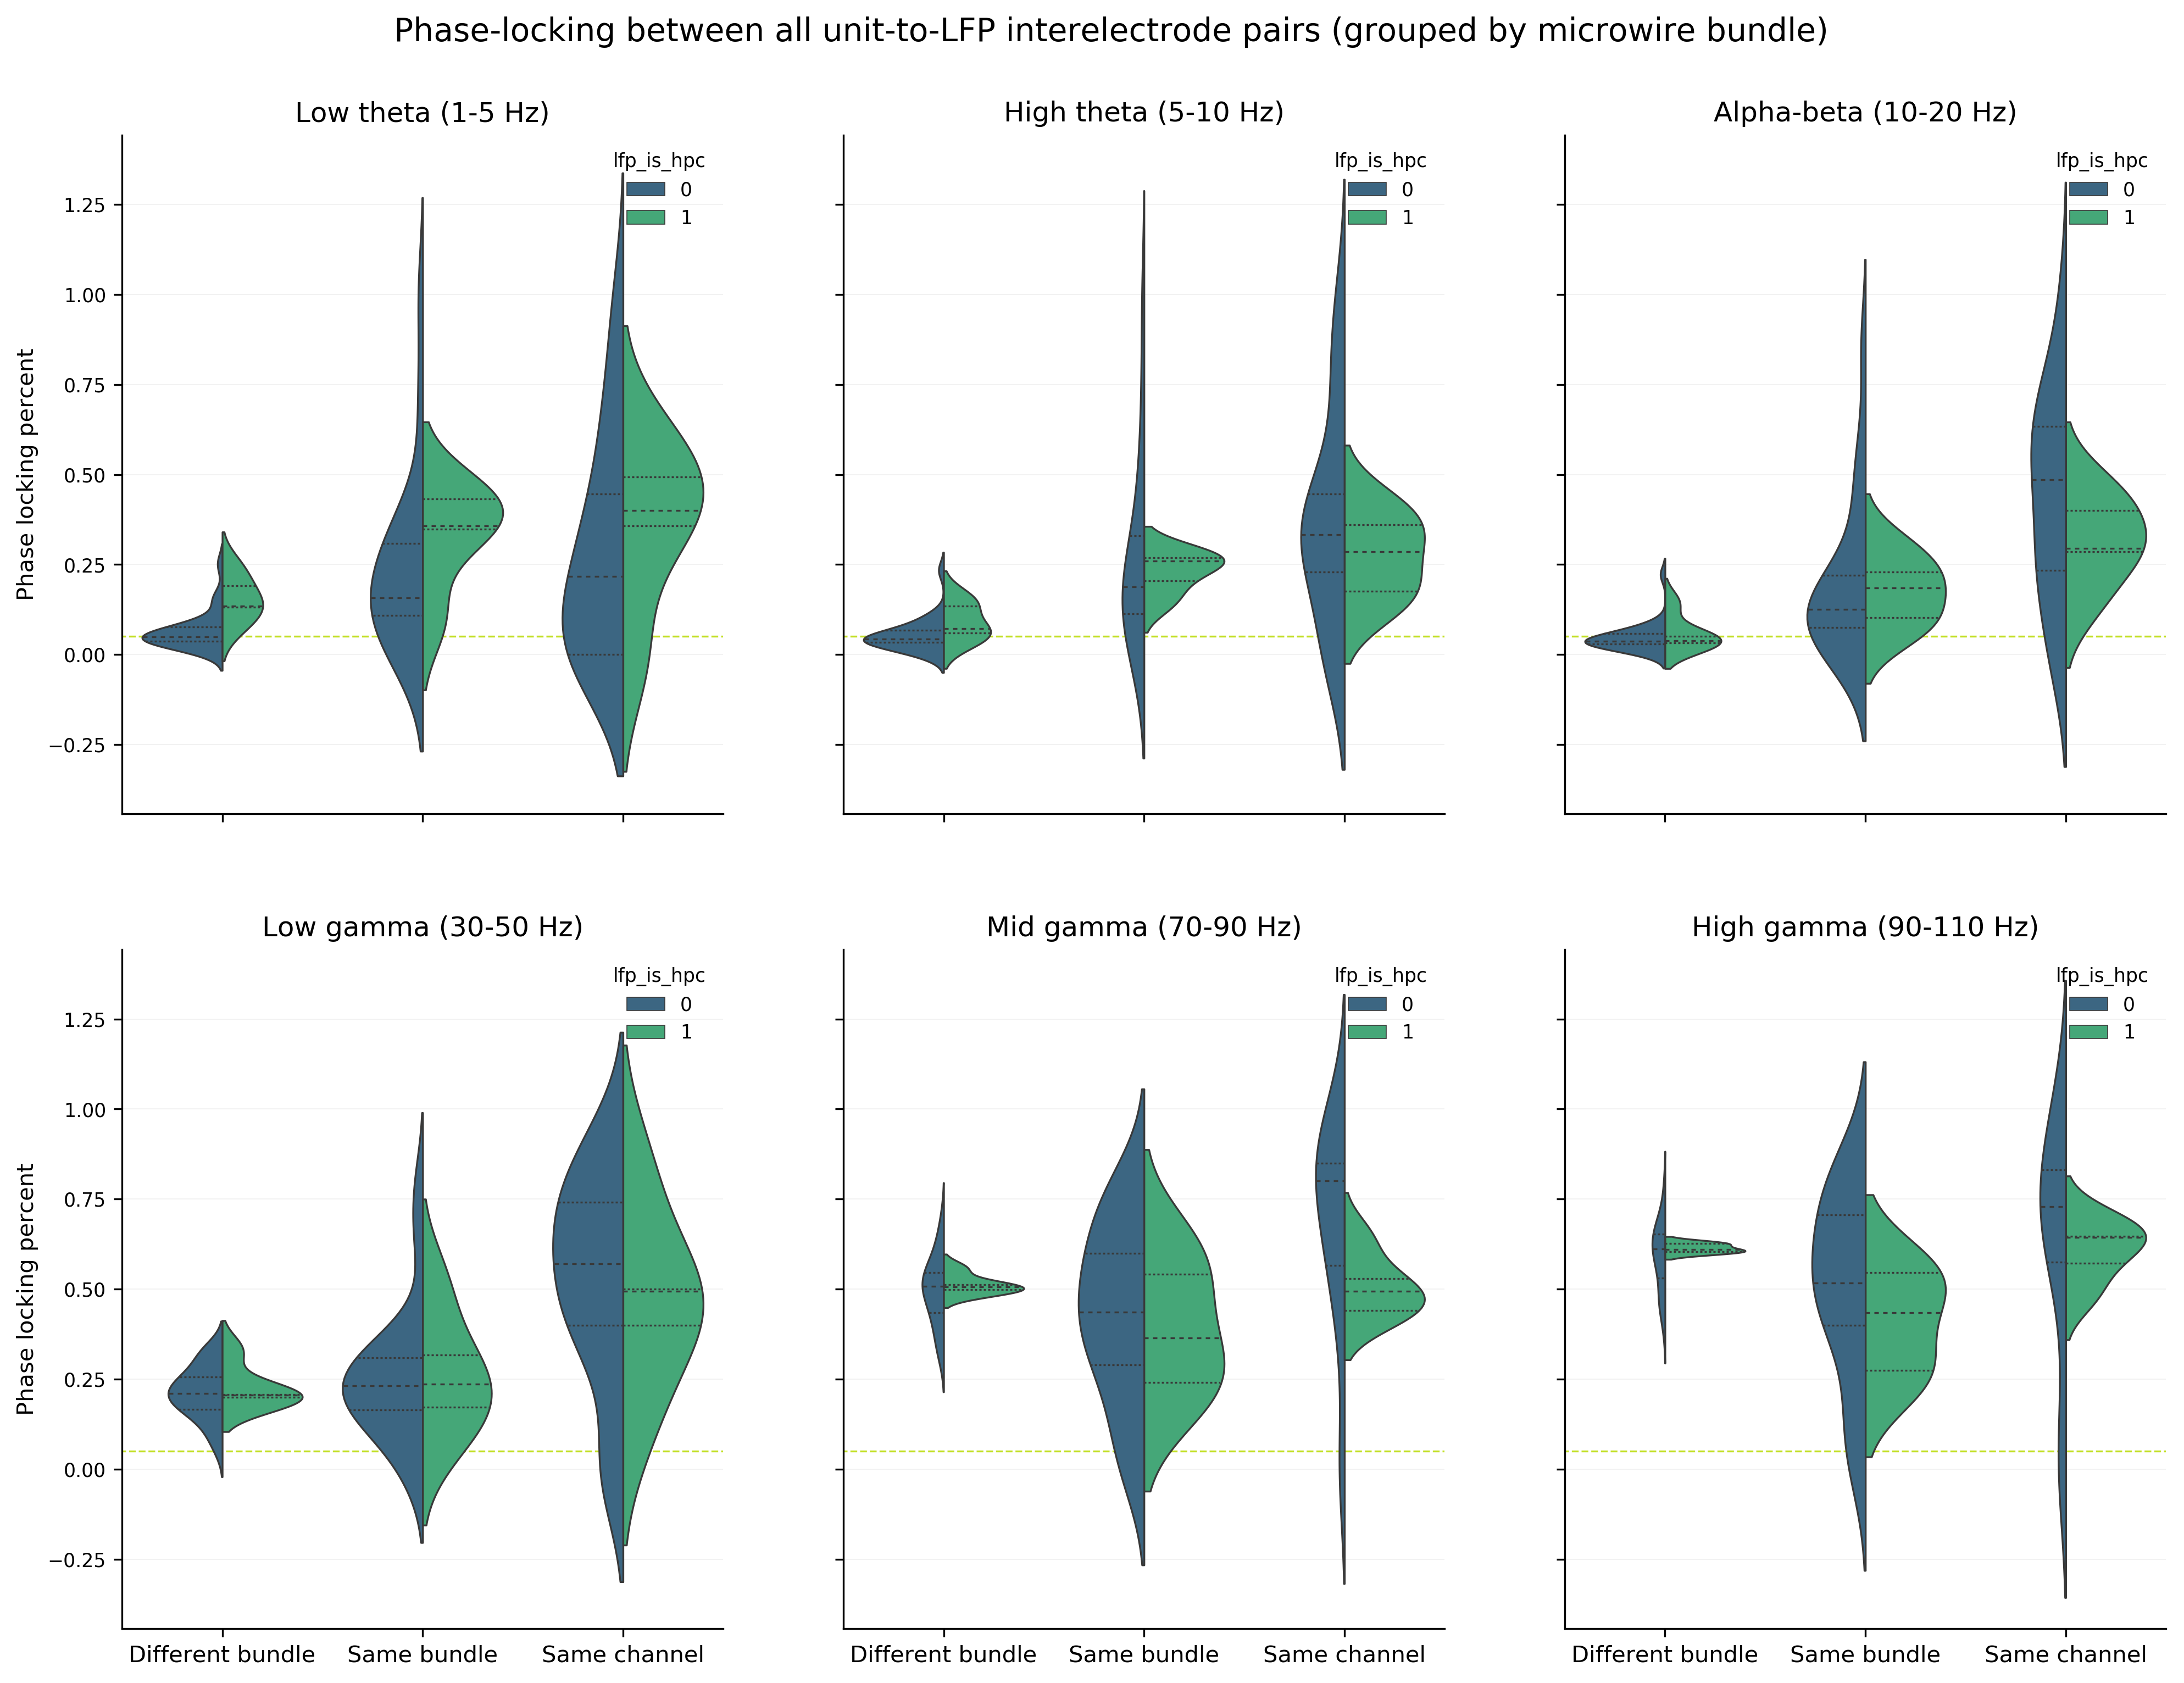

In [249]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 12), dpi=300)
ax = np.ravel(ax)

for i, band_name in enumerate(band_names):
    #ax[i].plot(np.arange(4), np.repeat(0.05, 4), color='C1')
    sns.violinplot(x='pair_type', y='pl_{}'.format(band_name), hue='lfp_is_hpc', data=grouped2[['pl_{}'.format(band_name)]].mean().reset_index(),
                   split=True, inner='quartile', palette='viridis', ax=ax[i])
    ax[i].hlines(0.05, -1, 4, color=sns.color_palette('viridis', 10)[9], linestyle='--', zorder=0)
    #ax[i].set_ylim([0, 1])
    ax[i].set_xticklabels(['Different bundle', 'Same bundle', 'Same channel'], fontsize=10)
    ax[i].set_xlabel('')
    if i in (0, 3):
        ax[i].set_ylabel('Phase locking percent', fontsize=10)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(bands_fancy[band_name], fontsize=12)
#     if i == 0:
#         ax[i].legend(['Non-hippocampal LFP', 'Hippocampal LFP'], loc=2, fontsize=10)
fig.suptitle('Phase-locking between all unit-to-LFP interelectrode pairs (grouped by microwire bundle)', fontsize=14, y=0.94)
#fig.tight_layout(w_pad=0, h_pad=0)

Text(0.5,0.94,'Phase-locking between all unit-to-LFP interelectrode pairs (grouped by session)')

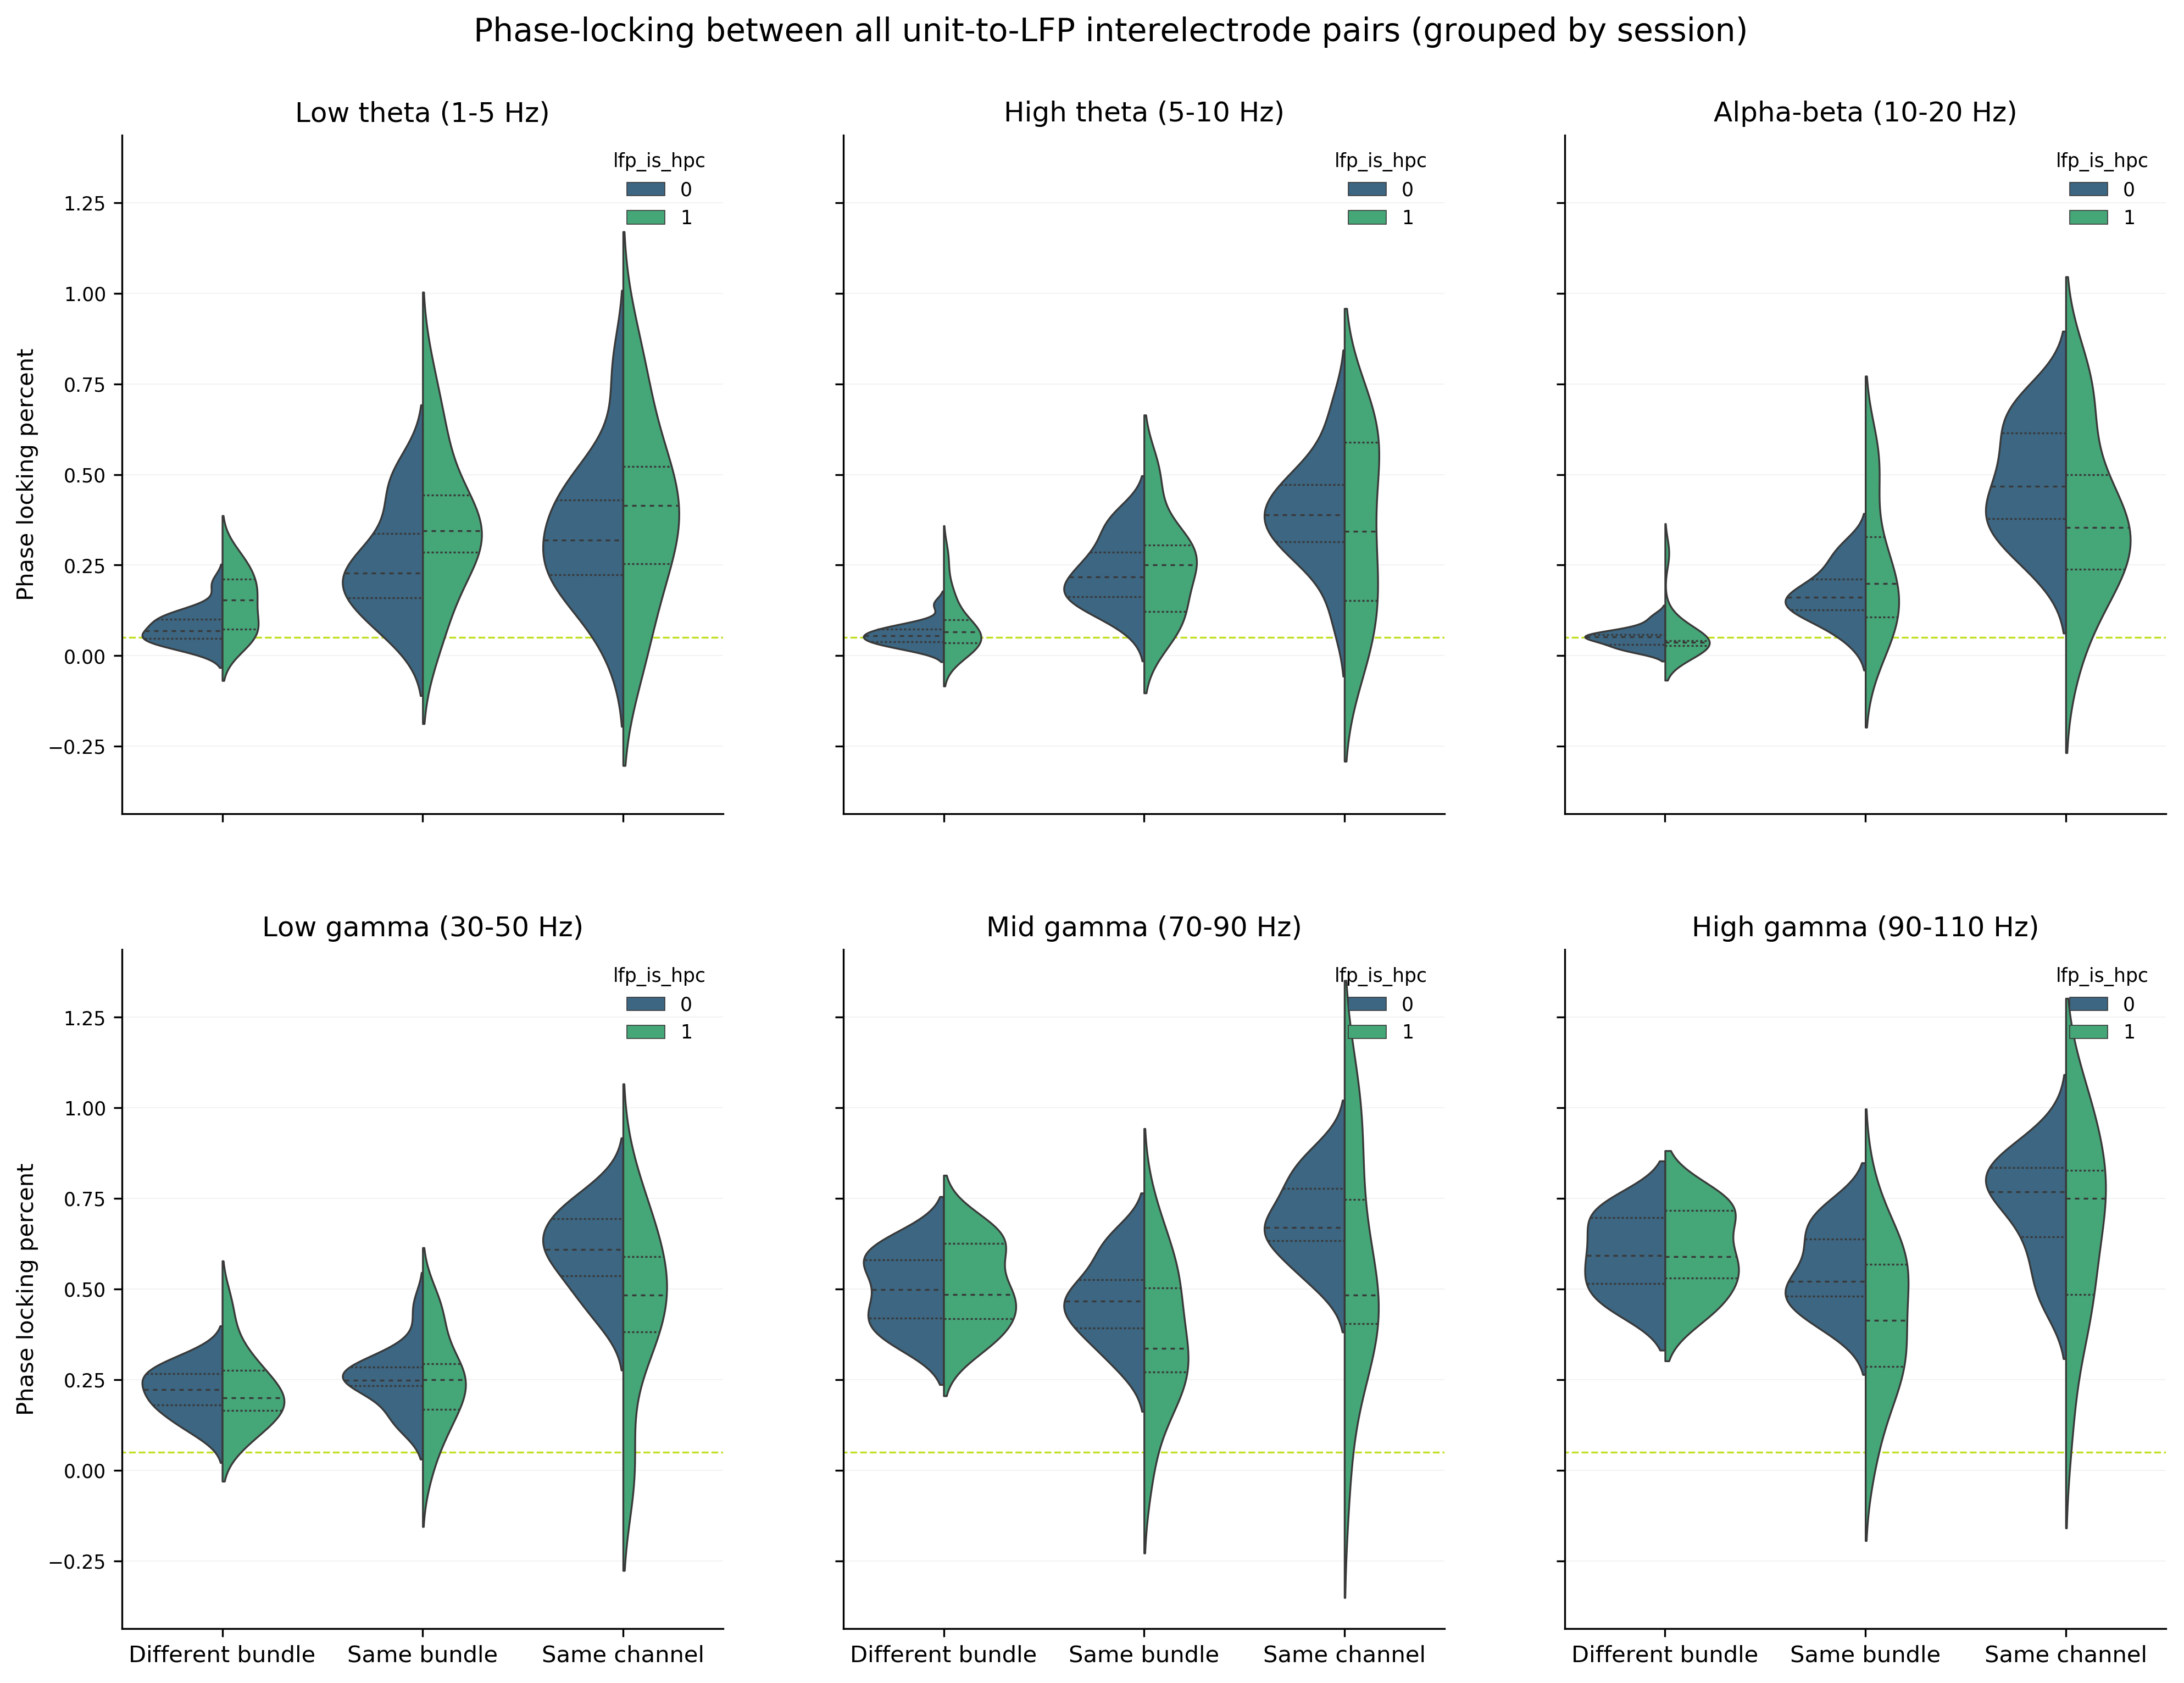

In [250]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 12), dpi=300)
ax = np.ravel(ax)

for i, band_name in enumerate(band_names):
    #ax[i].plot(np.arange(4), np.repeat(0.05, 4), color='C1')
    sns.violinplot(x='pair_type', y='pl_{}'.format(band_name), hue='lfp_is_hpc', data=grouped[['pl_{}'.format(band_name)]].mean().reset_index(),
                   split=True, inner='quartile', palette='viridis', ax=ax[i])
    ax[i].hlines(0.05, -1, 4, color=sns.color_palette('viridis', 10)[9], linestyle='--', zorder=0)
    #ax[i].set_ylim([0, 1])
    ax[i].set_xticklabels(['Different bundle', 'Same bundle', 'Same channel'], fontsize=10)
    ax[i].set_xlabel('')
    if i in (0, 3):
        ax[i].set_ylabel('Phase locking percent', fontsize=10)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(bands_fancy[band_name], fontsize=12)
#     if i == 0:
#         ax[i].legend(['Non-hippocampal LFP', 'Hippocampal LFP'], loc=2, fontsize=10)
fig.suptitle('Phase-locking between all unit-to-LFP interelectrode pairs (grouped by session)', fontsize=14, y=0.94)
#fig.tight_layout(w_pad=0, h_pad=0)

In [429]:
pd.DataFrame(df.query("(lfp_is_hpc == True) & (unit_is_hpc==False)").groupby(['unit_roi', 'unit_id']).pl2_alpha_beta.sum()).reset_index().sum()

unit_roi          AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
unit_id           U369_env1_0U369_env1_1U369_env1_10U369_env1_2U...
pl2_alpha_beta                                                  324
dtype: object

In [456]:
df.columns

Index(['subj_sess', 'unit_lfpchanind', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'lfp_chan',
       'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem', 'lfp_roi', 'lfp_is_hpc',
       'same_chan', 'same_hemroi', 'same_hem', 'same_roi', 'both_hpc',
       'spike_inds', 'spike_phases', 'means', 'lengths', 'pvals', 'pair_type',
       'pl_low_theta', 'pl_high_theta', 'pl_alpha_beta', 'pl_low_gamma',
       'pl_mid_gamma', 'pl_high_gamma', 'bundle_id', 'pair_id', 'unit_id',
       'pvals_hpcbonf', 'pl2_low_theta', 'pl2_high_theta', 'pl2_alpha_beta',
       'pl2_low_gamma', 'pl2_mid_gamma', 'pl2_high_gamma'],
      dtype='object')

In [480]:
np.unique(df.groupby('unit_id').unit_roi.unique().apply(lambda x: x[0]), return_counts=True)

(array(['A', 'AC', 'AH', 'EC', 'MC', 'MH', 'MST', 'OF', 'PG', 'PH', 'PO',
        'PS', 'PST', 'SAO', 'SMA', 'ST', 'TP'], dtype=object),
 array([149,  16, 100,  82,  19,  21,  12,  43,  81,  17,   8,  30,   3,
          2,  10,  39,   9]))

Text(0.5,1,'Phase locking of extra-hippocampal units to hippocampal low theta')

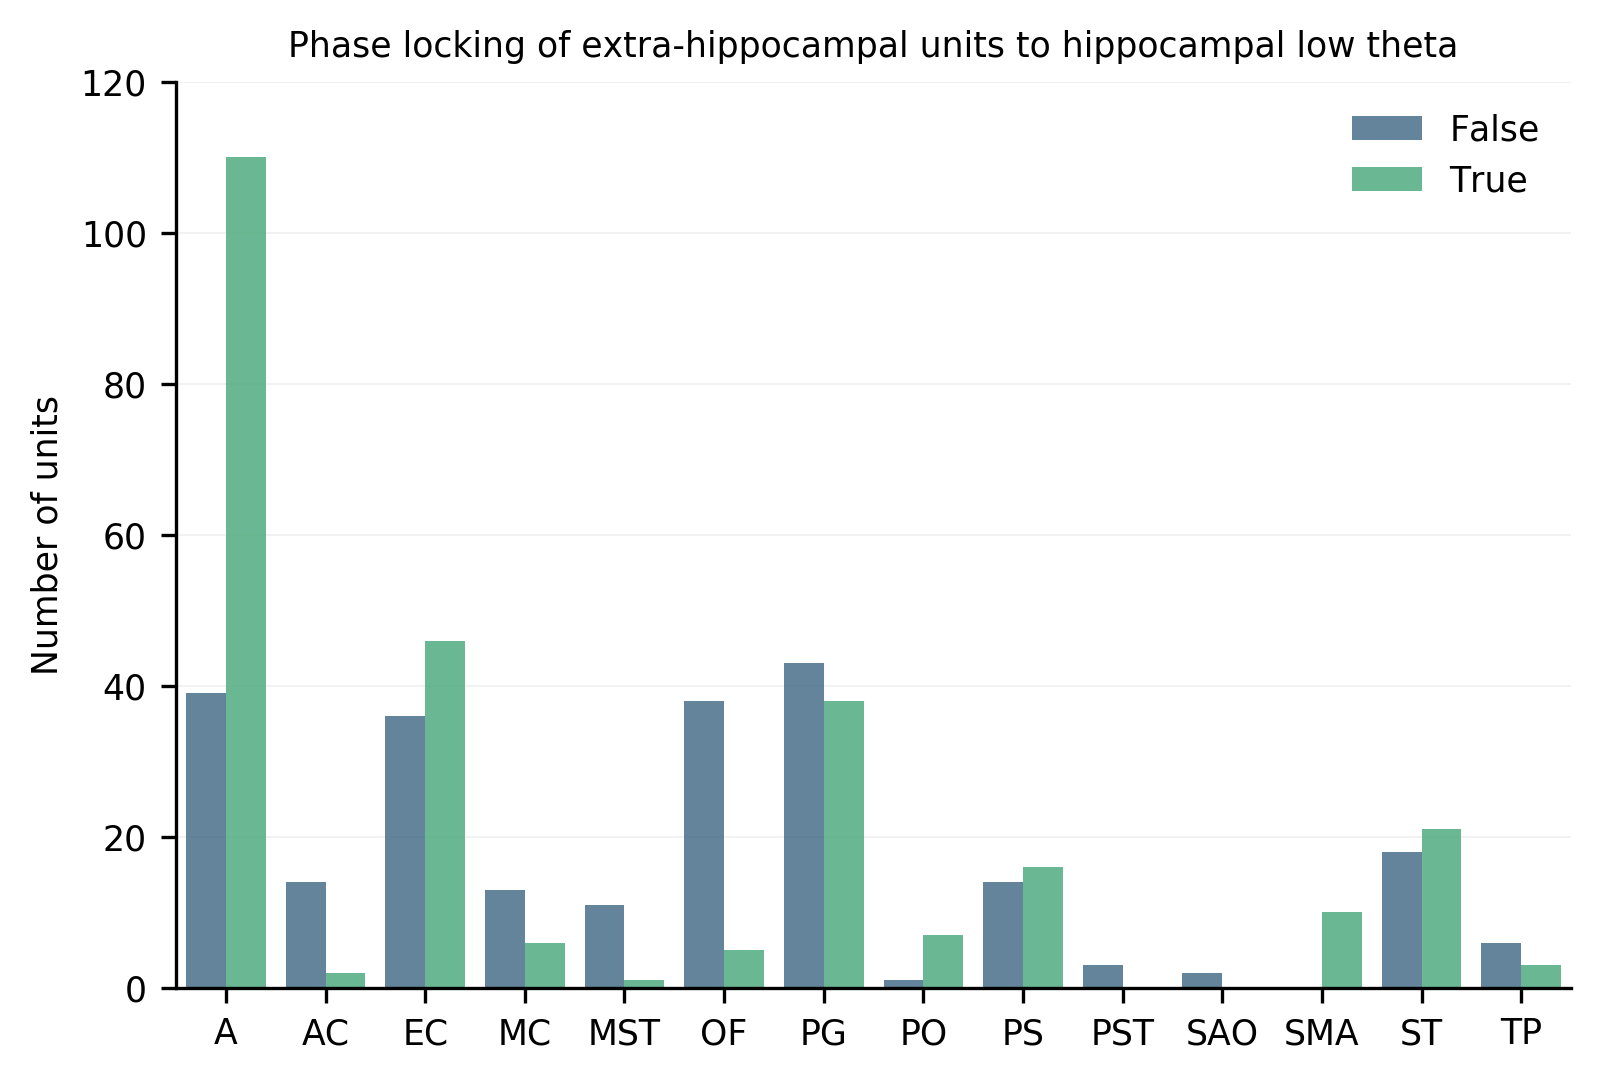

In [487]:
cat = 'low_theta'
df_ = pd.DataFrame(df.query("(lfp_is_hpc == True) & (unit_is_hpc==False)").groupby(['unit_roi', 'unit_id'])['pl2_{}'.format(cat)].sum()).reset_index()
df_['pl2_{}_bin'.format(cat)] = df_['pl2_{}'.format(cat)]>0 # each unit has a 5% chance of being miscategorized
df_ = df_.groupby(['unit_roi', 'pl2_{}_bin'.format(cat)]).count().reset_index()

fig, ax = plt.subplots(1, 1, dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi', y='unit_id', hue='pl2_{}_bin'.format(cat), data=df_,
            palette='viridis', alpha=0.8, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_yticks(np.linspace(0, 120, 7))
ax[0].set_ylabel('Number of units')
ax[0].legend(loc=1)
ax[0].set_title('Phase locking of extra-hippocampal units to hippocampal low theta')

Text(0.5,1,'Phase locking of extra-hippocampal units to hippocampal high theta')

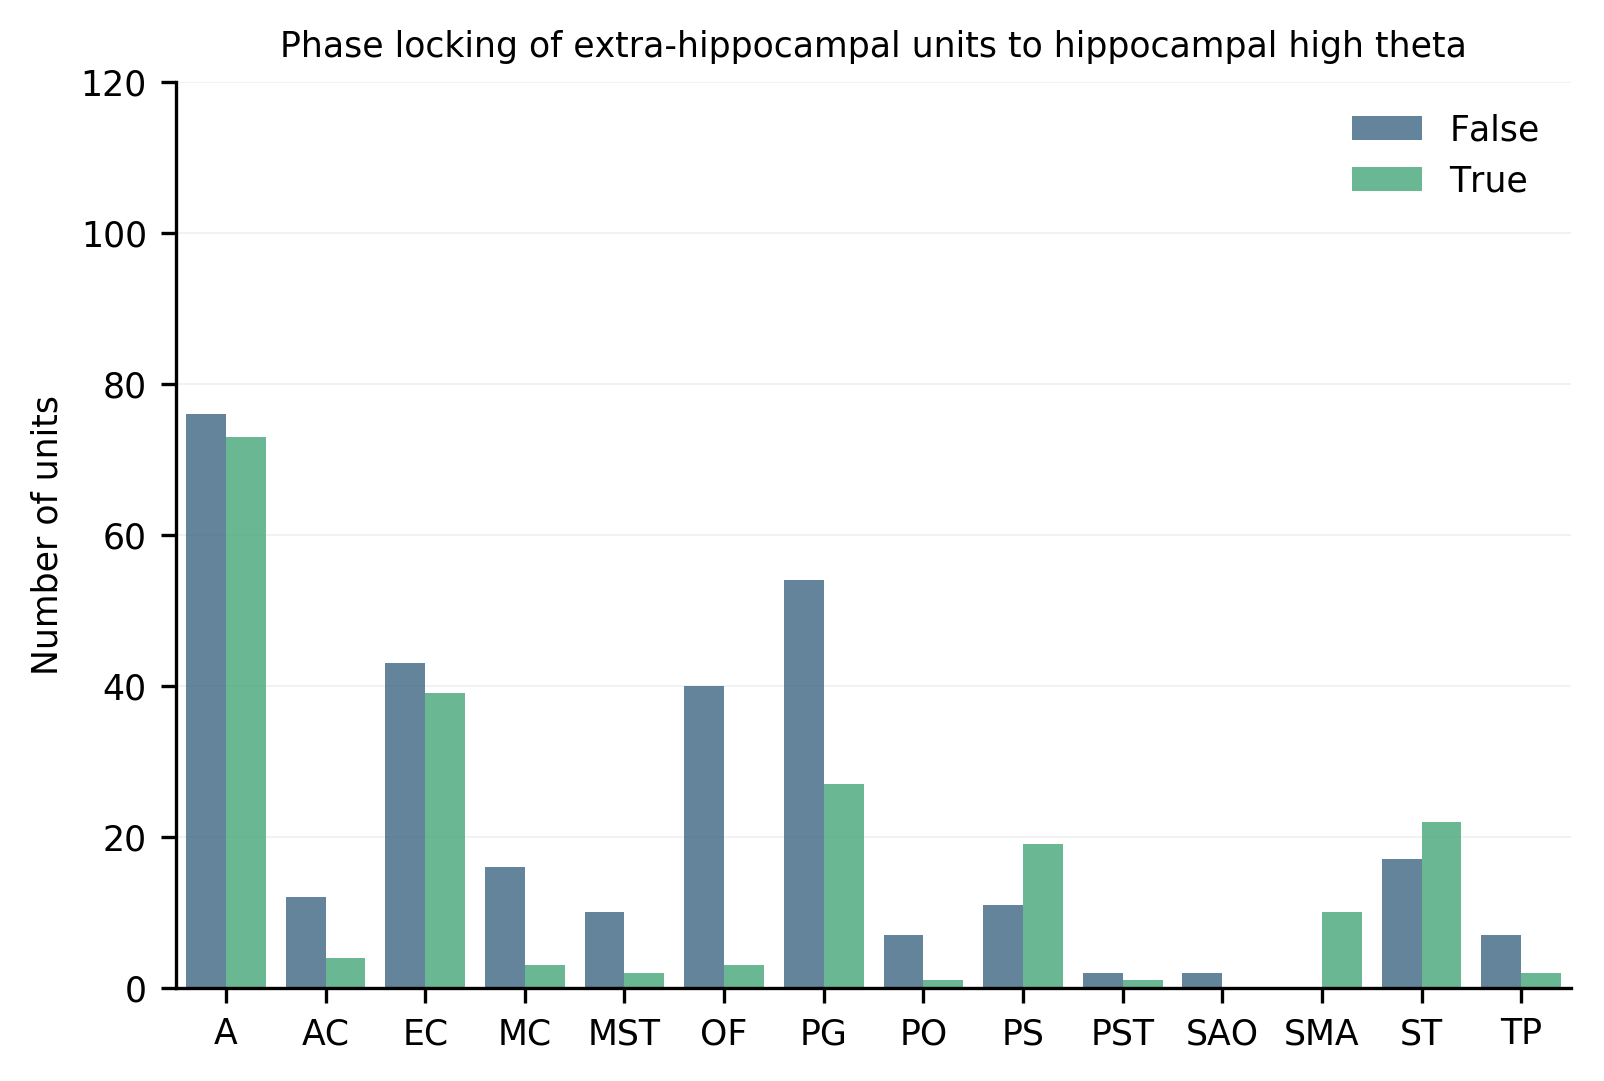

In [489]:
cat = 'high_theta'
df_ = pd.DataFrame(df.query("(lfp_is_hpc == True) & (unit_is_hpc==False)").groupby(['unit_roi', 'unit_id'])['pl2_{}'.format(cat)].sum()).reset_index()
df_['pl2_{}_bin'.format(cat)] = df_['pl2_{}'.format(cat)]>0 # each unit has a 5% chance of being miscategorized
df_ = df_.groupby(['unit_roi', 'pl2_{}_bin'.format(cat)]).count().reset_index()

fig, ax = plt.subplots(1, 1, dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi', y='unit_id', hue='pl2_{}_bin'.format(cat), data=df_,
            palette='viridis', alpha=0.8, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_yticks(np.linspace(0, 120, 7))
ax[0].set_ylabel('Number of units')
ax[0].legend(loc=1)
ax[0].set_title('Phase locking of extra-hippocampal units to hippocampal high theta')

Text(0.5,1,'Phase locking of extra-hippocampal units to hippocampal alpha-beta')

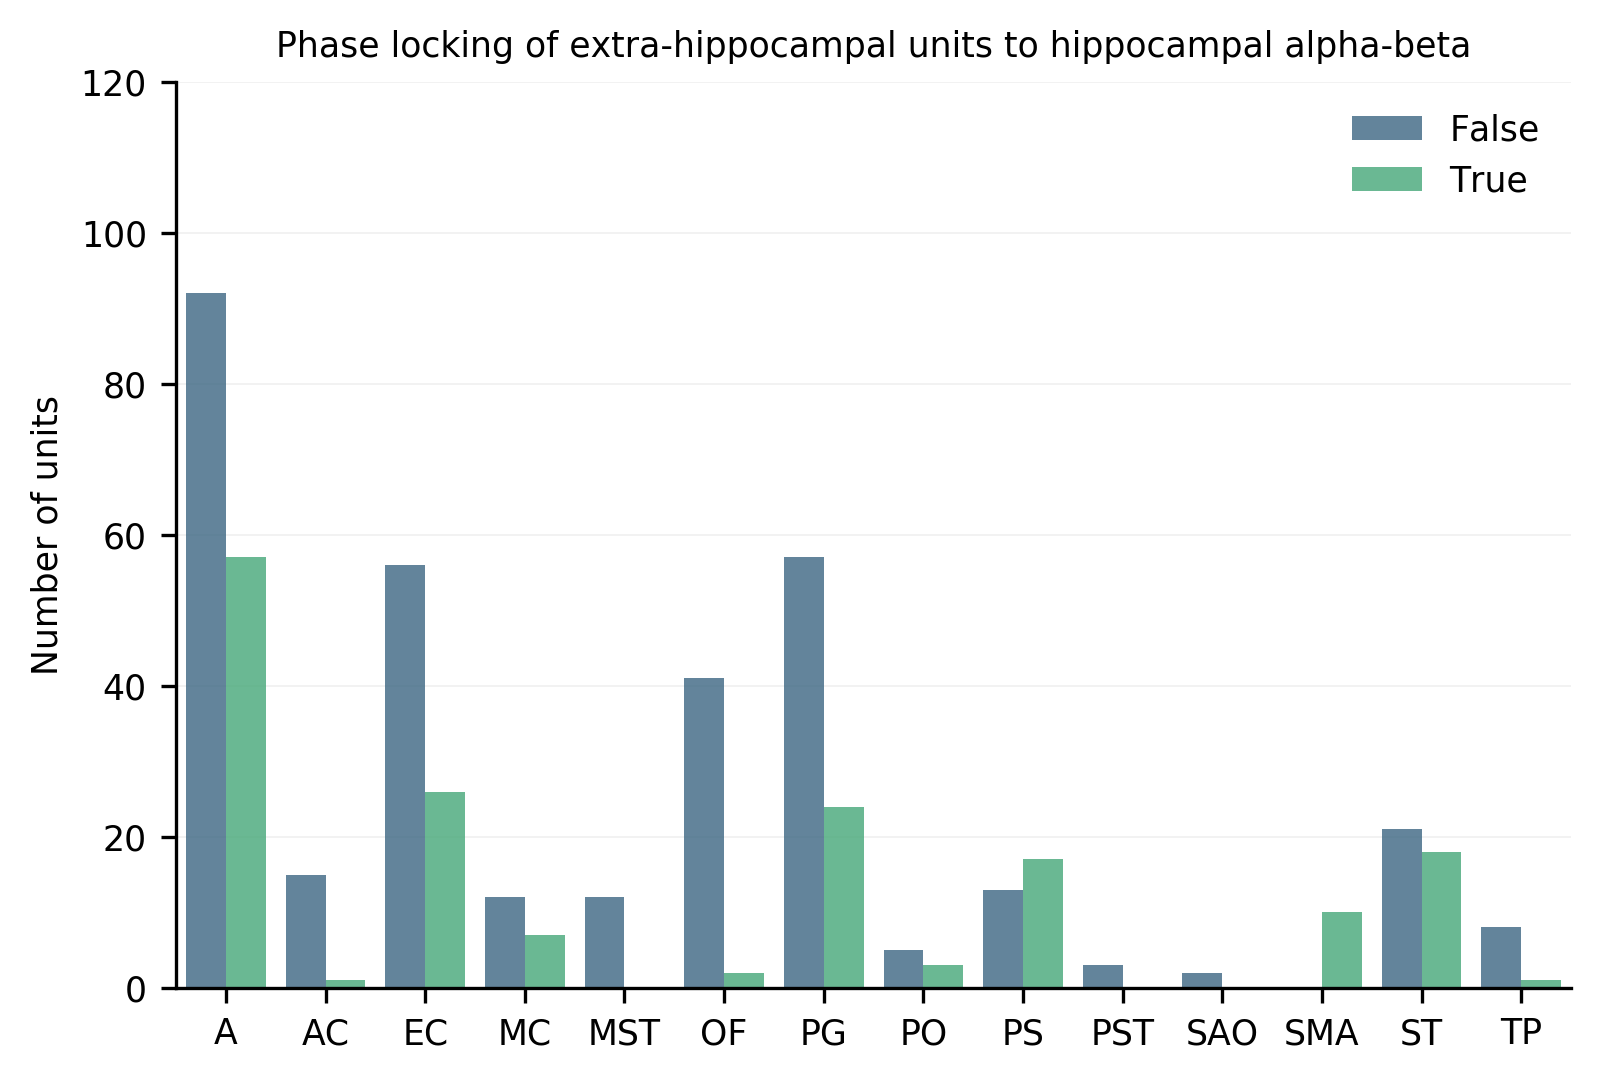

In [491]:
cat = 'alpha_beta'
df_ = pd.DataFrame(df.query("(lfp_is_hpc == True) & (unit_is_hpc==False)").groupby(['unit_roi', 'unit_id'])['pl2_{}'.format(cat)].sum()).reset_index()
df_['pl2_{}_bin'.format(cat)] = df_['pl2_{}'.format(cat)]>0 # each unit has a 5% chance of being miscategorized
df_ = df_.groupby(['unit_roi', 'pl2_{}_bin'.format(cat)]).count().reset_index()

fig, ax = plt.subplots(1, 1, dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi', y='unit_id', hue='pl2_{}_bin'.format(cat), data=df_,
            palette='viridis', alpha=0.8, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_yticks(np.linspace(0, 120, 7))
ax[0].set_ylabel('Number of units')
ax[0].legend(loc=1)
ax[0].set_title('Phase locking of extra-hippocampal units to hippocampal alpha-beta')

Text(0.5,1,'Phase locking of non-hippocampal units to hippocampal high theta')

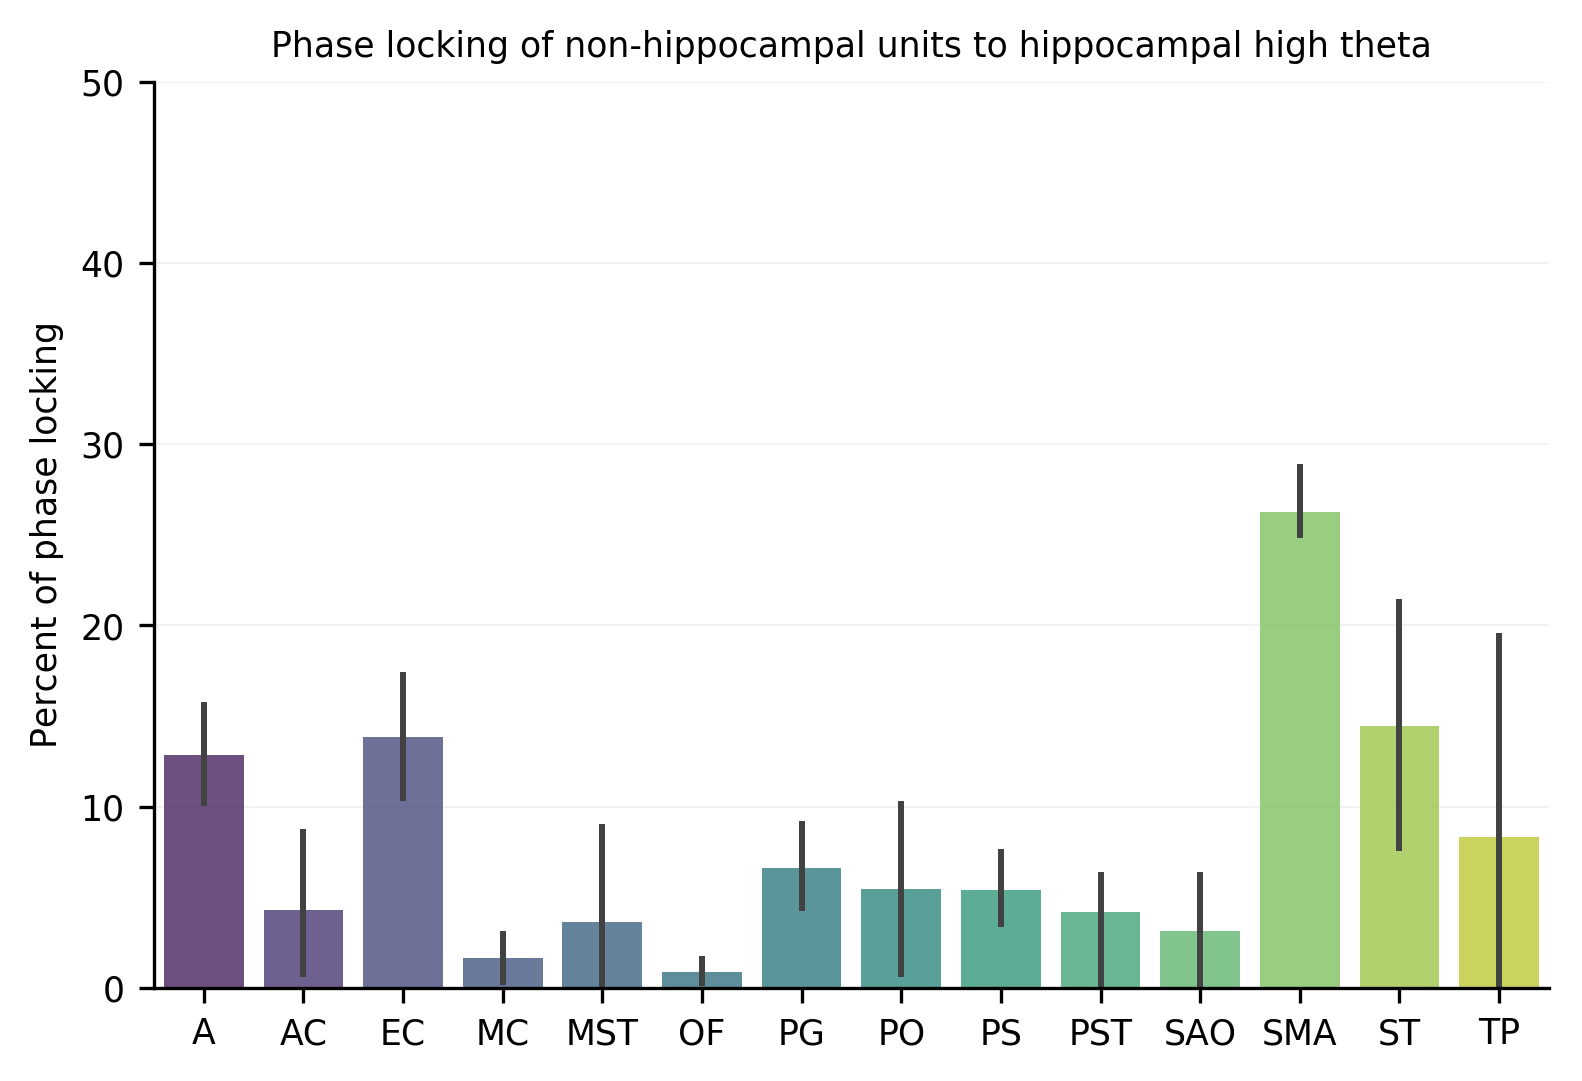

In [341]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi', y='pl_high_theta', 
            data=pd.DataFrame(df.query("(lfp_is_hpc == True) & (unit_is_hpc==False)")
                              .groupby(['unit_roi', 'unit_id']).pl_high_theta.mean()).reset_index(),
            palette='viridis', alpha=0.8, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_yticks(np.linspace(0, 0.5, 6))
ax[0].set_yticklabels([int(100*x) for x in np.linspace(0, 0.5, 6)])
ax[0].set_ylabel('Percent of phase locking')
ax[0].set_title('Phase locking of non-hippocampal units to hippocampal high theta')

Text(0.5,1,'Phase locking of non-hippocampal units to hippocampal alpha-beta')

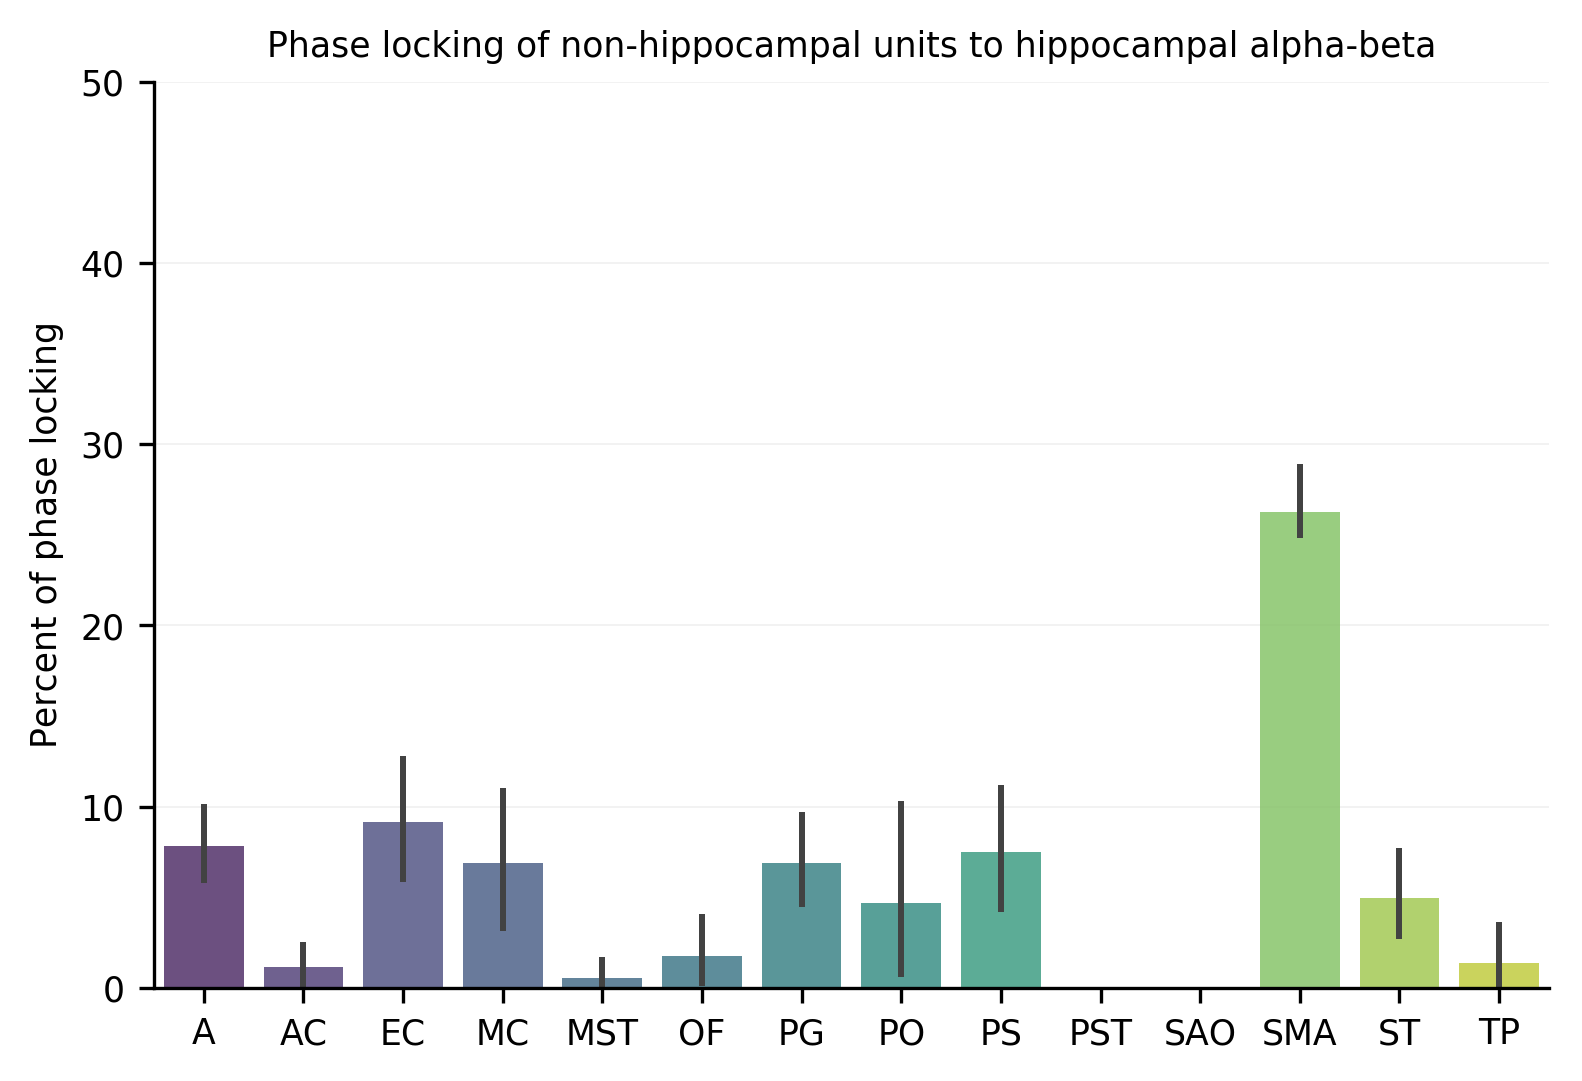

In [343]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi', y='pl_alpha_beta', 
            data=pd.DataFrame(df.query("(lfp_is_hpc == True) & (unit_is_hpc==False)")
                              .groupby(['unit_roi', 'unit_id']).pl_alpha_beta.mean()).reset_index(),
            palette='viridis', alpha=0.8, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_yticks(np.linspace(0, 0.5, 6))
ax[0].set_yticklabels([int(100*x) for x in np.linspace(0, 0.5, 6)])
ax[0].set_ylabel('Percent of phase locking')
ax[0].set_title('Phase locking of non-hippocampal units to hippocampal alpha-beta')

In [226]:
for i in range(6):
    print('{}:'.format(list(bands_fancy.values())[i]))
    
    df = cepl_df
    print('All unit->LFP pairs (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    
    
    df = cepl_df.query("(same_chan==True)")
    print('Same channel (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_chan==True) & (unit_is_hpc==False) & (unit_roi!='A')")
    print('Same channel (Ctx) (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_chan==True) & (unit_is_hpc==False) & (unit_roi=='A')")
    print('Same channel (Amy) (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_chan==True) & (unit_is_hpc==True)")
    print('Same channel (Hpc) (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    
    
    df = cepl_df.query("(same_chan==False) & (same_hemroi==True)")
    print('Different channel, same bundle (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_chan==False) & (same_hemroi==True) & (unit_is_hpc==False) & (unit_roi!='A')")
    print('Different channel, same bundle (Ctx) (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_chan==False) & (same_hemroi==True) & (unit_is_hpc==False) & (unit_roi=='A')")
    print('Different channel, same bundle (Amy) (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_chan==False) & (same_hemroi==True) & (unit_is_hpc==True)")
    print('Different channel, same bundle (HPC) (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    
    
    df = cepl_df.query("(same_roi==False)")
    print('Different region (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_roi==False) & (unit_is_hpc==False) & (lfp_is_hpc==False) & (unit_roi!='A') & (lfp_roi!='A')")
    print('Different regions, Ctx->Ctx (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_roi==False) & (unit_is_hpc==False) & (lfp_is_hpc==False) & (unit_roi=='A') & (lfp_roi=='A')")
    print('Different regions, Amy->Amy (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(same_roi==False) & (unit_is_hpc==True) & (lfp_is_hpc==True)")
    print('Different regions, Hpc->Hpc (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    
    
    df = cepl_df.query("(unit_is_hpc==False) & (lfp_is_hpc==True) & (unit_roi=='A')")
    print('Amy spikes->Hpc LFP (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(unit_is_hpc==True) & (lfp_is_hpc==False) & (lfp_roi=='A')")
    print('Hpc spikes->Amy LFP (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(unit_is_hpc==False) & (lfp_is_hpc==False) & (unit_roi=='A') & (lfp_roi!='A')")
    print('Amy spikes->Ctx LFP (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(unit_is_hpc==False) & (lfp_is_hpc==False) & (unit_roi!='A') & (lfp_roi=='A')")
    print('Ctx spikes->Amy LFP (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(unit_is_hpc==False) & (lfp_is_hpc==True) & (unit_roi!='A')")
    print('Ctx spikes->Hpc LFP (N={}): {:.04f}'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))
    
    df = cepl_df.query("(unit_is_hpc==True) & (lfp_is_hpc==False) & (lfp_roi!='A')")
    print('Hpc spikes->Ctx LFP (N={}): {:.04f}\n'.format(len(df), np.sum(df.pvals.apply(lambda x: x[i]<bonf_alpha)) / len(df)))

## What is going on with gamma phase-locking?
Test the hypothesis that brain-wide noise may be contributing to false spikes and LFP inflections

In [1015]:
spikes, fr_df, clus_to_chan, chan_to_clus = phase_locking.load_spikes(sessions[0])

In [1016]:
spike_trains = np.array(fr_df.spikes.tolist())

In [1027]:
arr10 = aop.rolling_func(spike_trains, np.sum, window=21, right_fill=0) # 30ms time window
arr10 = np.roll(arr10, shift=10, axis=1) # center each window on its original time
arr10[arr10>0] = 1 # 1 if a spike is observed in the window

arr30 = aop.rolling_func(spike_trains, np.sum, window=61, right_fill=0) # 30ms time window
arr30 = np.roll(arr30, shift=30, axis=1) # center each window on its original time
arr30[arr30>0] = 1 # 1 if a spike is observed in the window

arr100 = aop.rolling_func(spike_trains, np.sum, window=201, right_fill=0) # 30ms time window
arr100 = np.roll(arr100, shift=100, axis=1) # center each window on its original time
arr100[arr100>0] = 1 # 1 if a spike is observed in the window

In [1028]:
xvals10, yvals10 = np.unique(np.sum(arr10, axis=0), return_counts=True)
xvals30, yvals30 = np.unique(np.sum(arr30, axis=0), return_counts=True)
xvals100, yvals100 = np.unique(np.sum(arr100, axis=0), return_counts=True)

In [1022]:
arr = aop.rolling_func(spike_trains, np.sum, window=61, right_fill=0) # 30ms time window
arr = np.roll(arr, shift=30, axis=1) # center each window on its original time
arr[arr>0] = 1 # 1 if a spike is observed in the window

In [1023]:
xvals, yvals = np.unique(np.sum(arr, axis=0), return_counts=True)

In [1024]:
np.percentile(np.sum(arr, axis=0), 75)

8.0

In [1025]:
# The mask identifies all timepoints where the number of units with 1+ co-occuring spikes within a 30ms window
mask = np.tile(np.sum(arr, axis=0)<np.percentile(np.sum(arr, axis=0), 75), reps=arr.shape[0]).reshape(arr.shape)

Text(0.5,1,'Co-occuring spikes across units')

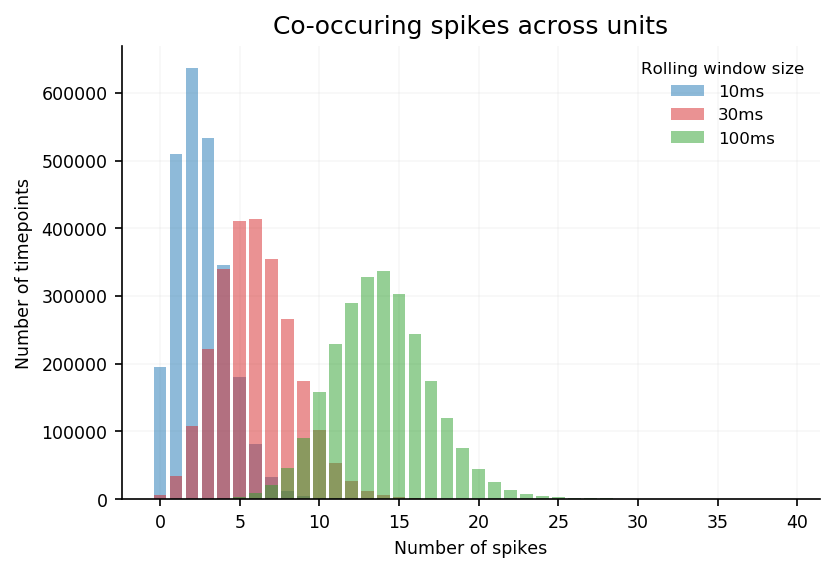

In [1048]:
plt.figure(dpi=150)
plt.bar(xvals10, yvals10, alpha=0.5, label='10ms')
plt.bar(xvals30, yvals30, alpha=0.5, label='30ms')
plt.bar(xvals100, yvals100, alpha=0.5, label='100ms')
plt.xlabel('Number of spikes')
plt.ylabel('Number of timepoints')
legend = plt.legend(title='Rolling window size', fontsize=8)
plt.setp(legend.get_title(),fontsize=8)
plt.title('Co-occuring spikes across units', fontsize=12)